In [2]:
import sys
sys.path.append("/remote/gpu03/schiller/JetCalibration")

import torch
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import numpy
import os
from tqdm import tqdm

from Source.plots import compute_range, figs_hist1d, figs_hist_twice
from Source.plots import colors as atlas_colors

2025-08-09 17:26:21.306845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754753181.328763 2454299 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754753181.335231 2454299 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754753181.352750 2454299 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754753181.352772 2454299 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754753181.352774 2454299 computation_placer.cc:177] computation placer alr

# Helper functions

In [3]:
@torch.inference_mode()
def load_gmm_predictions(run):
    pred = torch.load(os.path.join(run, "test_predictions.pt"), map_location="cpu", weights_only=True)
    pred["sigma"] = torch.linalg.inv(pred["sigma_inv"])
    return pred

@torch.inference_mode()
def compute_total_covariance(weights, mus, sigmas):
    mean = torch.sum(weights.unsqueeze(-1) * mus, dim=1)
    mean_diff = mus - mean.unsqueeze(1)  
    outer = mean_diff.unsqueeze(-1) * mean_diff.unsqueeze(-2)
    total_cov = torch.sum(
        weights.unsqueeze(-1).unsqueeze(-1) * (sigmas + outer),
        dim=1
    )

    return total_cov

@torch.inference_mode()
def compute_cor_frac(cov):
    sigma_1 = torch.sqrt(cov[:,0,0])
    sigma_2 = torch.sqrt(cov[:,1,1])
    cor = cov[:,0,1] / (sigma_1 * sigma_2)
    return cor

## Tests

In [4]:
pred = load_gmm_predictions("/remote/gpu03/schiller/JetCalibration/results/20250716_225717_Multivariate_GMM2")

In [5]:
print(pred.keys())
print(pred["sigma"].shape)

dict_keys(['mu', 'sigma_inv', 'weights', 'preprocess_mean', 'preprocess_std', 'sigma'])
torch.Size([7307831, 9, 2, 2])


In [6]:
total_cov = compute_total_covariance(pred["weights"], pred["mu"], pred["sigma"])
cor = compute_cor_frac(total_cov)

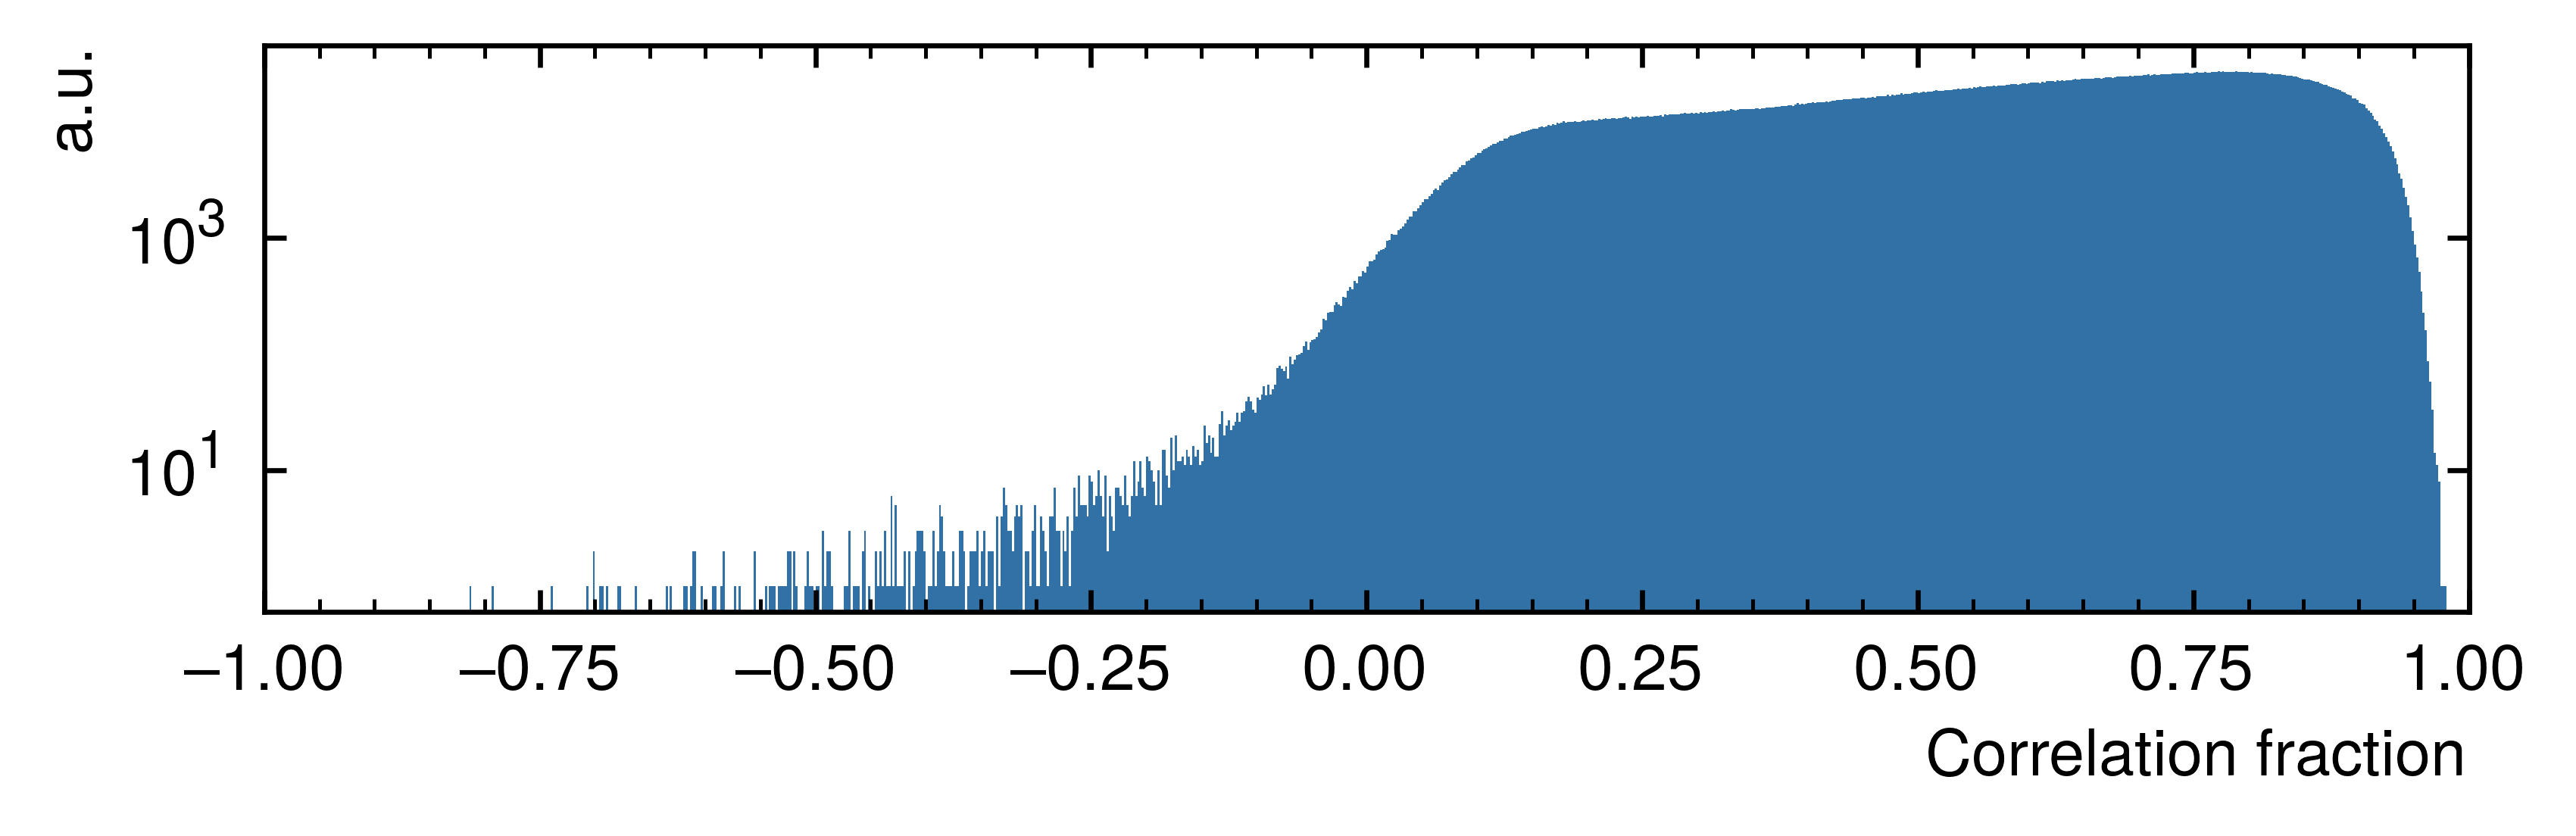

In [7]:
fig, ax = plt.subplots(figsize=(6, 2))
_, bins, _ = ax.hist(cor, bins=1000, range=[-1.,1.])
ax.set_ylabel("a.u.")
ax.set_xlabel("Correlation fraction")
# ax.set_xlim(bins[0], bins[-1])
ax.set_xlim(-1, 1)
fig.tight_layout()
ax.set_yscale("log")

plt.show()

Distance: 5.0 sigma


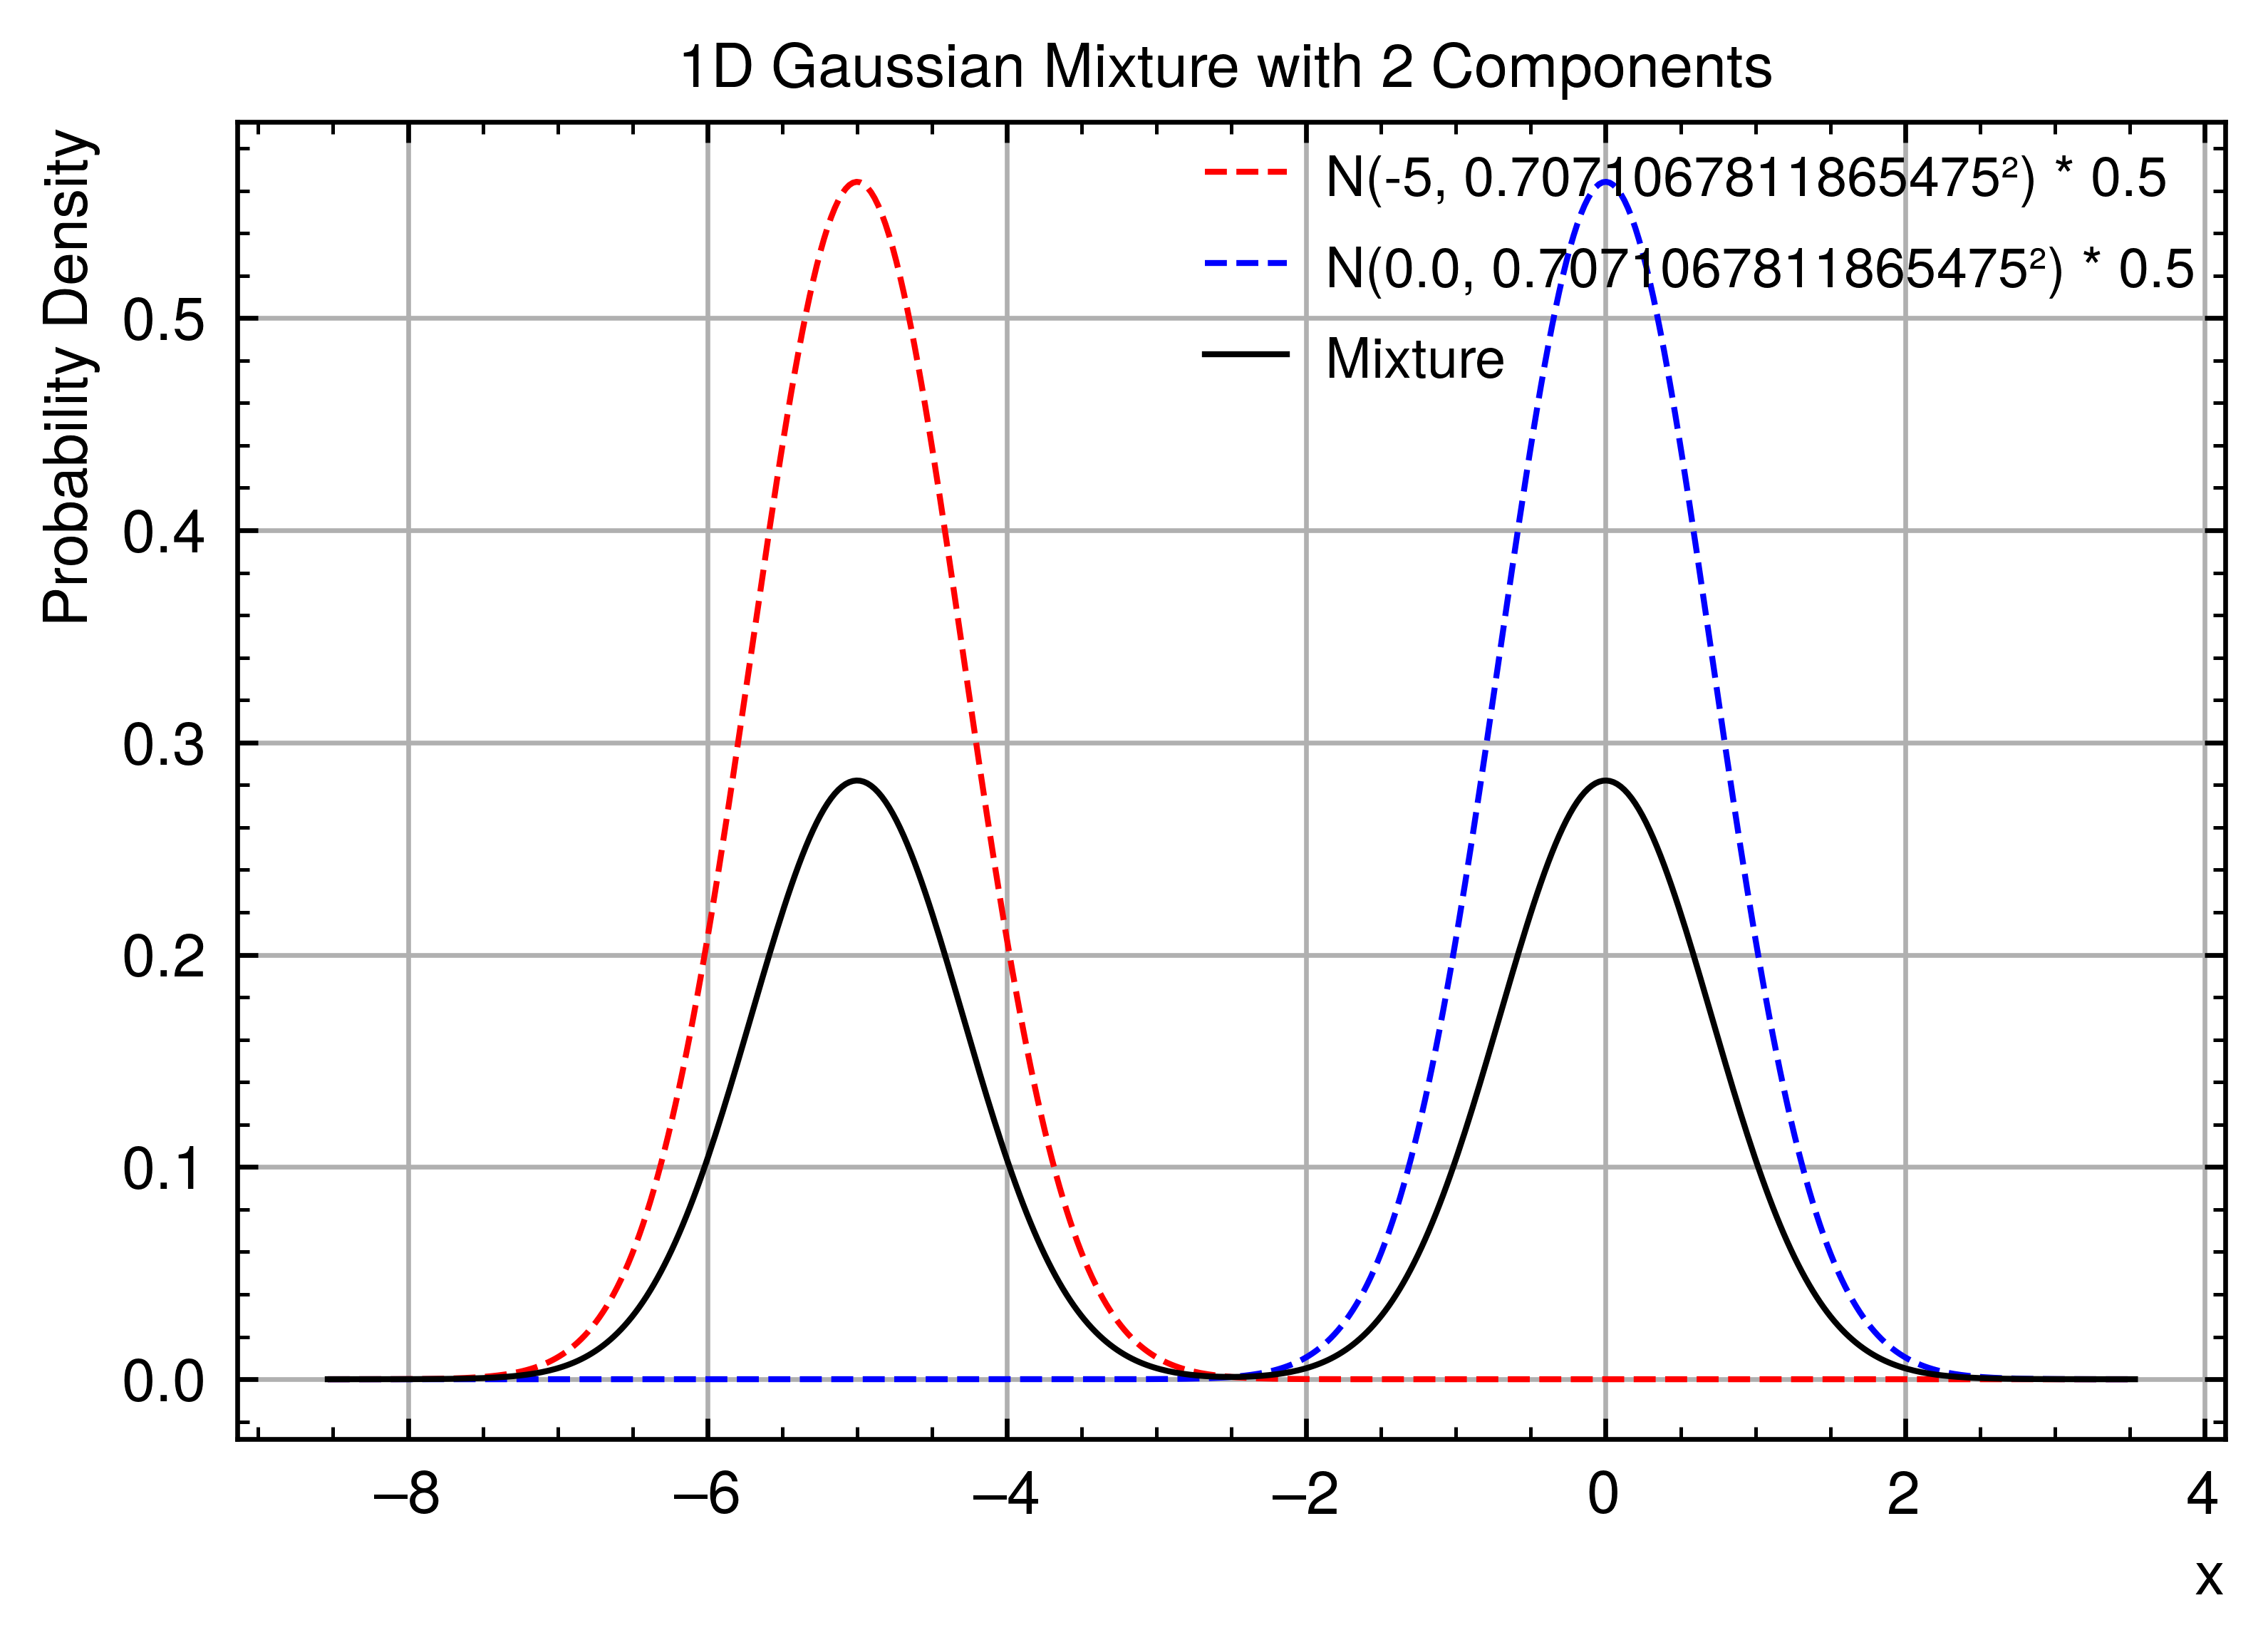

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
mu1 = -5
mu2 = 0.
sigma = 1 / np.sqrt(2)
w1 = 0.5
w2 = 0.5

print(f"Distance: {np.abs(mu1 - mu2) / np.sqrt(2 * sigma**2):.1f} sigma")

# x range
x = np.linspace(mu1 - 5 * sigma, mu2 + 5 * sigma, 500)

# Component PDFs
pdf1 = norm.pdf(x, mu1, sigma)
pdf2 = norm.pdf(x, mu2, sigma)

# Mixture PDF
pdf_mix = w1 * pdf1 + w2 * pdf2

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x, pdf1, 'r--', label=f'N({mu1}, {sigma}²) * {w1}')
plt.plot(x, pdf2, 'b--', label=f'N({mu2}, {sigma}²) * {w2}')
plt.plot(x, pdf_mix, 'k-', label='Mixture')
plt.legend()
plt.title('1D Gaussian Mixture with 2 Components')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


In [12]:
import torch
import numpy as np
from scipy.ndimage import maximum_filter, label, generate_binary_structure

def gaussian_pdf_2d(x, mean, cov):
    # x: [..., 2]
    diff = x - mean
    inv_cov = torch.linalg.inv(cov)
    exponent = -0.5 * torch.einsum('...i,ij,...j->...', diff, inv_cov, diff)
    norm_const = 1.0 / (2 * np.pi * torch.sqrt(torch.det(cov)))
    return norm_const * torch.exp(exponent)

def mixture_pdf(grid, weights, mus, covs):
    # weights: [N], mus: [N, 2], covs: [N, 2, 2]
    pdf = torch.zeros(grid.shape[:-1])
    for w, mu, cov in zip(weights, mus, covs):
        pdf += w * gaussian_pdf_2d(grid, mu, cov)
    return pdf

def compute_eff_number_of_modes_with_vis(weights, mus, sigmas, rel_threshold=0.05):

    min_x, max_x = -3., 3.
    min_y, max_y = -3., 3.

    converged = False
    iteration = 1

    old_num_modes = None
    old_mode_coords = None

    while not converged:
        xs = torch.linspace(min_x, max_x, 200)
        ys = torch.linspace(min_y, max_y, 200)
        X, Y = torch.meshgrid(xs, ys, indexing='ij')
        grid_points = torch.stack([X, Y], dim=-1)

        # Evaluate mixture PDF
        pdf_vals = mixture_pdf(grid_points, weights, mus, sigmas).numpy()

        neighborhood = generate_binary_structure(2, 2)
        local_max = (maximum_filter(pdf_vals, footprint=neighborhood) == pdf_vals)

        # Threshold to avoid counting tiny bumps
        mask = local_max & (pdf_vals > pdf_vals.max() * rel_threshold)

        # Label connected components (modes)
        labeled, num_modes = label(mask)

        print(f"[{iteration}]: Estimated number of modes: {num_modes}")
        print(f"Pdf vals: {pdf_vals[mask]}")

        mode_coords = np.array([np.mean(np.argwhere(labeled == i), axis=0) for i in range(1, num_modes+1)])
        mode_coords_xy = np.stack([xs[mode_coords[:,0].astype(int)], ys[mode_coords[:,1].astype(int)]], axis=1)
        
        _converged = True
        if iteration == 1:
            _converged = False
        else:
            if num_modes != old_num_modes:
                _converged = False
            else:
                diff_coords = np.abs(old_mode_coords - mode_coords_xy)
                changed = np.sum(diff_coords > 0.01)
                if changed:
                    _converged = False

        converged = _converged
        print(f"Converged: {converged}")
        
        if not converged:
            min_x, max_x = np.min(mode_coords_xy[:,0]), np.max(mode_coords_xy[:,0])
            min_y, max_y = np.min(mode_coords_xy[:,1]), np.max(mode_coords_xy[:,1])

            diff_x, diff_y = max_x - min_x, max_y - min_y
            diff_x = max(diff_x, 0.15)
            diff_y = max(diff_y, 0.15)

            min_x, max_x = min_x - 0.2 * diff_x, max_x + 0.2 * diff_x
            min_y, max_y = min_y - 0.2 * diff_y, max_y + 0.2 * diff_y

            old_num_modes = num_modes
            old_mode_coords = mode_coords_xy

            iteration += 1

    vmin = pdf_vals.min() + 1e-12
    vmax = pdf_vals.max()
    levels = np.logspace(np.log10(vmin), np.log10(vmax), 100)

    # --- Plot ---
    plt.close()
    plt.figure(figsize=(6, 2))
    plt.contourf(
        X.numpy(),
        Y.numpy(),
        pdf_vals,
        # levels=50,
        levels=levels,
        cmap='viridis',
        norm=mcolors.LogNorm(vmin=pdf_vals.min() + 1e-12, vmax=pdf_vals.max())
    )
    plt.colorbar(label='PDF value')

    # Mark modes on plot
    plt.scatter(mode_coords_xy[:,0], mode_coords_xy[:,1], c='red', marker='x', s=80, label='Modes')

    plt.title('2D Gaussian Mixture PDF and Modes')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    # plt.legend()
    plt.show()

def compute_eff_number_of_modes(weights, mus, sigmas, relative_to_max=False, rel_threshold=0.05):
    min_x, max_x = -3., 3.
    min_y, max_y = -3., 3.

    converged = False
    iteration = 1

    old_num_modes = None
    old_mode_coords = None

    while not converged:
        xs = torch.linspace(min_x, max_x, 200)
        ys = torch.linspace(min_y, max_y, 200)
        X, Y = torch.meshgrid(xs, ys, indexing='ij')
        grid_points = torch.stack([X, Y], dim=-1)

        # Evaluate mixture PDF
        pdf_vals = mixture_pdf(grid_points, weights, mus, sigmas).numpy()

        neighborhood = generate_binary_structure(2, 2)
        local_max = (maximum_filter(pdf_vals, footprint=neighborhood) == pdf_vals)

        # Threshold to avoid counting tiny bumps
        mask = local_max & (pdf_vals > pdf_vals.max() * rel_threshold)

        # Label connected components (modes)
        labeled, num_modes = label(mask)

        mode_coords = np.array([np.mean(np.argwhere(labeled == i), axis=0) for i in range(1, num_modes+1)])
        mode_coords_xy = np.stack([xs[mode_coords[:,0].astype(int)], ys[mode_coords[:,1].astype(int)]], axis=1)
        
        _converged = True
        if iteration == 1:
            _converged = False
        else:
            if num_modes != old_num_modes:
                _converged = False
            else:
                diff_coords = np.abs(old_mode_coords - mode_coords_xy)
                changed = int(np.sum(diff_coords > 0.01))
                if changed > 0:
                    _converged = False

        converged = _converged

        if not converged:
            min_x, max_x = np.min(mode_coords_xy[:,0]), np.max(mode_coords_xy[:,0])
            min_y, max_y = np.min(mode_coords_xy[:,1]), np.max(mode_coords_xy[:,1])

            diff_x, diff_y = max_x - min_x, max_y - min_y
            diff_x = max(diff_x, 0.15)
            diff_y = max(diff_y, 0.15)

            min_x, max_x = min_x - 0.2 * diff_x, max_x + 0.2 * diff_x
            min_y, max_y = min_y - 0.2 * diff_y, max_y + 0.2 * diff_y

            old_num_modes = num_modes
            old_mode_coords = mode_coords_xy

            iteration += 1

    if relative_to_max:
        return np.sum(pdf_vals[mask] / pdf_vals.max())

    return num_modes

[1]: Estimated number of modes: 2
Pdf vals: [0.74649006 0.2126    ]
Converged: False
[2]: Estimated number of modes: 2
Pdf vals: [0.7473906  0.21554594]
Converged: False
[3]: Estimated number of modes: 2
Pdf vals: [0.7474023  0.21557032]
Converged: True


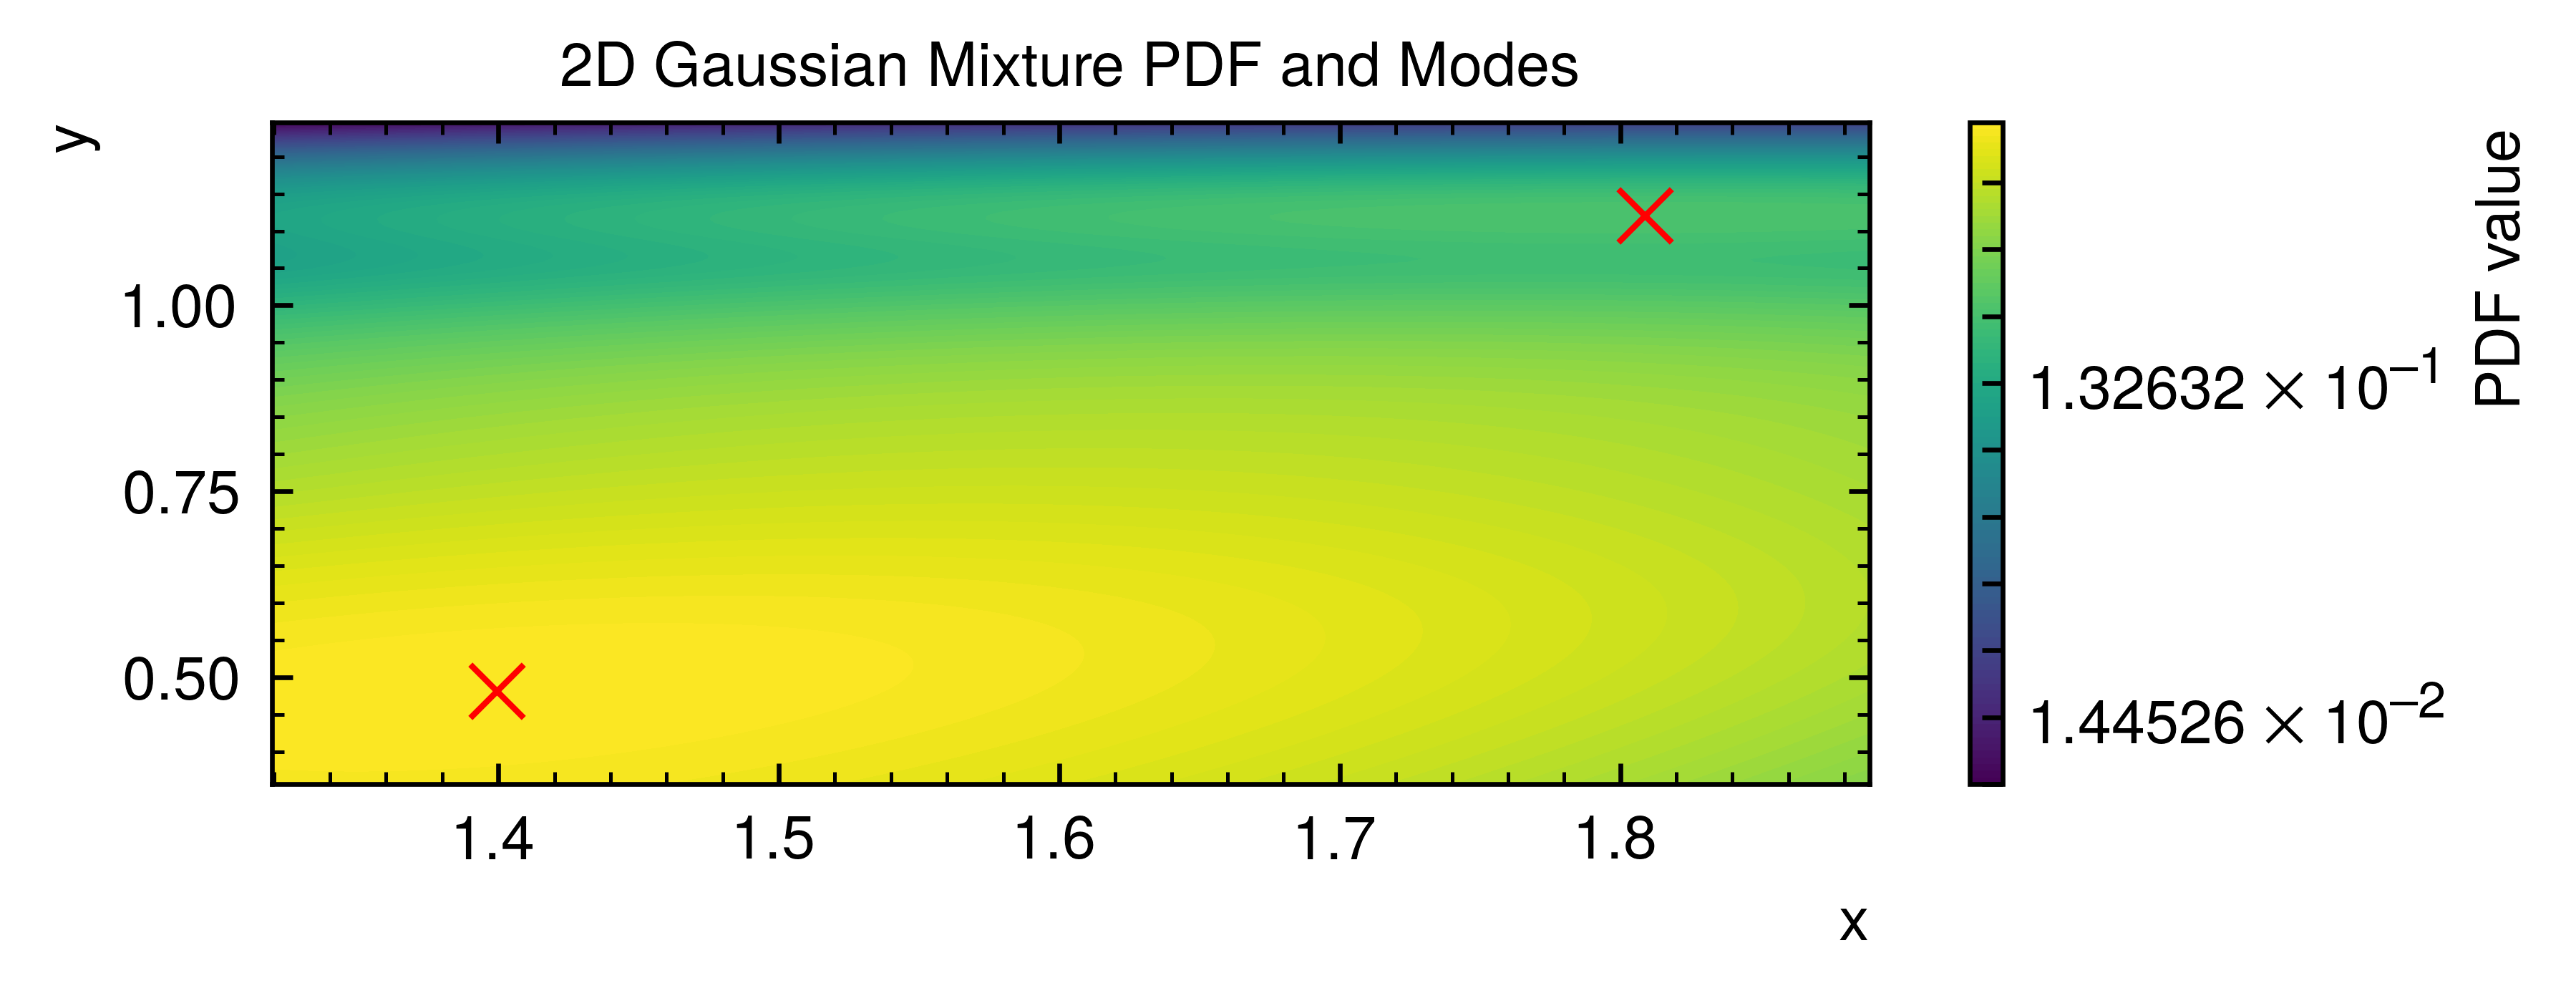

In [13]:
i = 100

compute_eff_number_of_modes_with_vis(
    weights = pred["weights"][i],
    mus = pred["mu"][i],
    sigmas = pred["sigma"][i]
)

In [ ]:
num_modes = []
for i in tqdm(range(pred["weights"].shape[0] // 1000)):
    num_modes.append((i, compute_eff_number_of_modes(
        weights = pred["weights"][i],
        mus = pred["mu"][i],
        sigmas = pred["sigma"][i],
        relative_to_max=False,
        rel_threshold=0.
    )))

num_modes_rel = []
for i in tqdm(range(pred["weights"].shape[0] // 1000)):
    num_modes_rel.append((i,compute_eff_number_of_modes(
        weights = pred["weights"][i],
        mus = pred["mu"][i],
        sigmas = pred["sigma"][i],
        relative_to_max=True,
        rel_threshold=0.
    )))

  0%|          | 4/7307 [00:11<07:43, 15.75it/s]

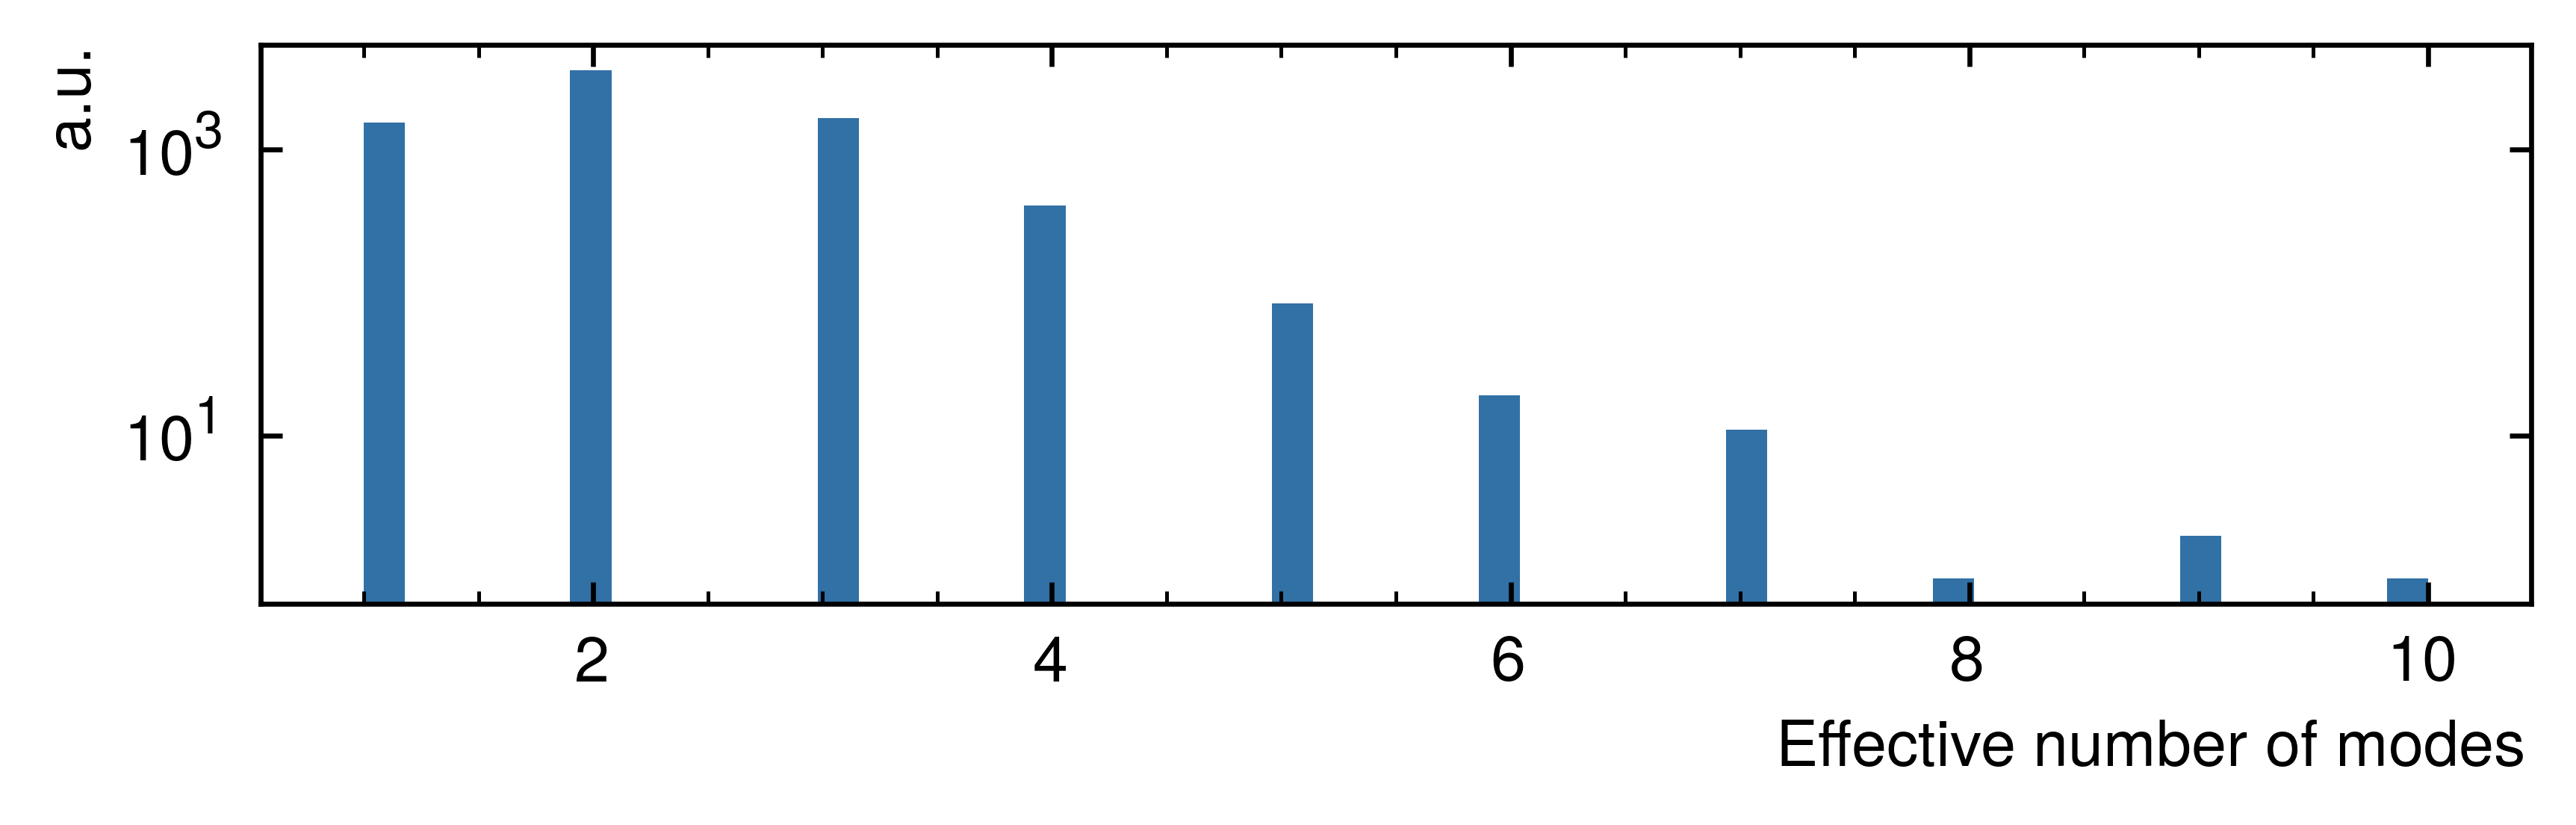

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
vals, _, _ = ax.hist([n for _, n in num_modes])
ax.set_ylabel("Counts")
ax.set_xlabel("Effective number of modes")
fig.tight_layout()
ax.set_yscale("log")

plt.show()

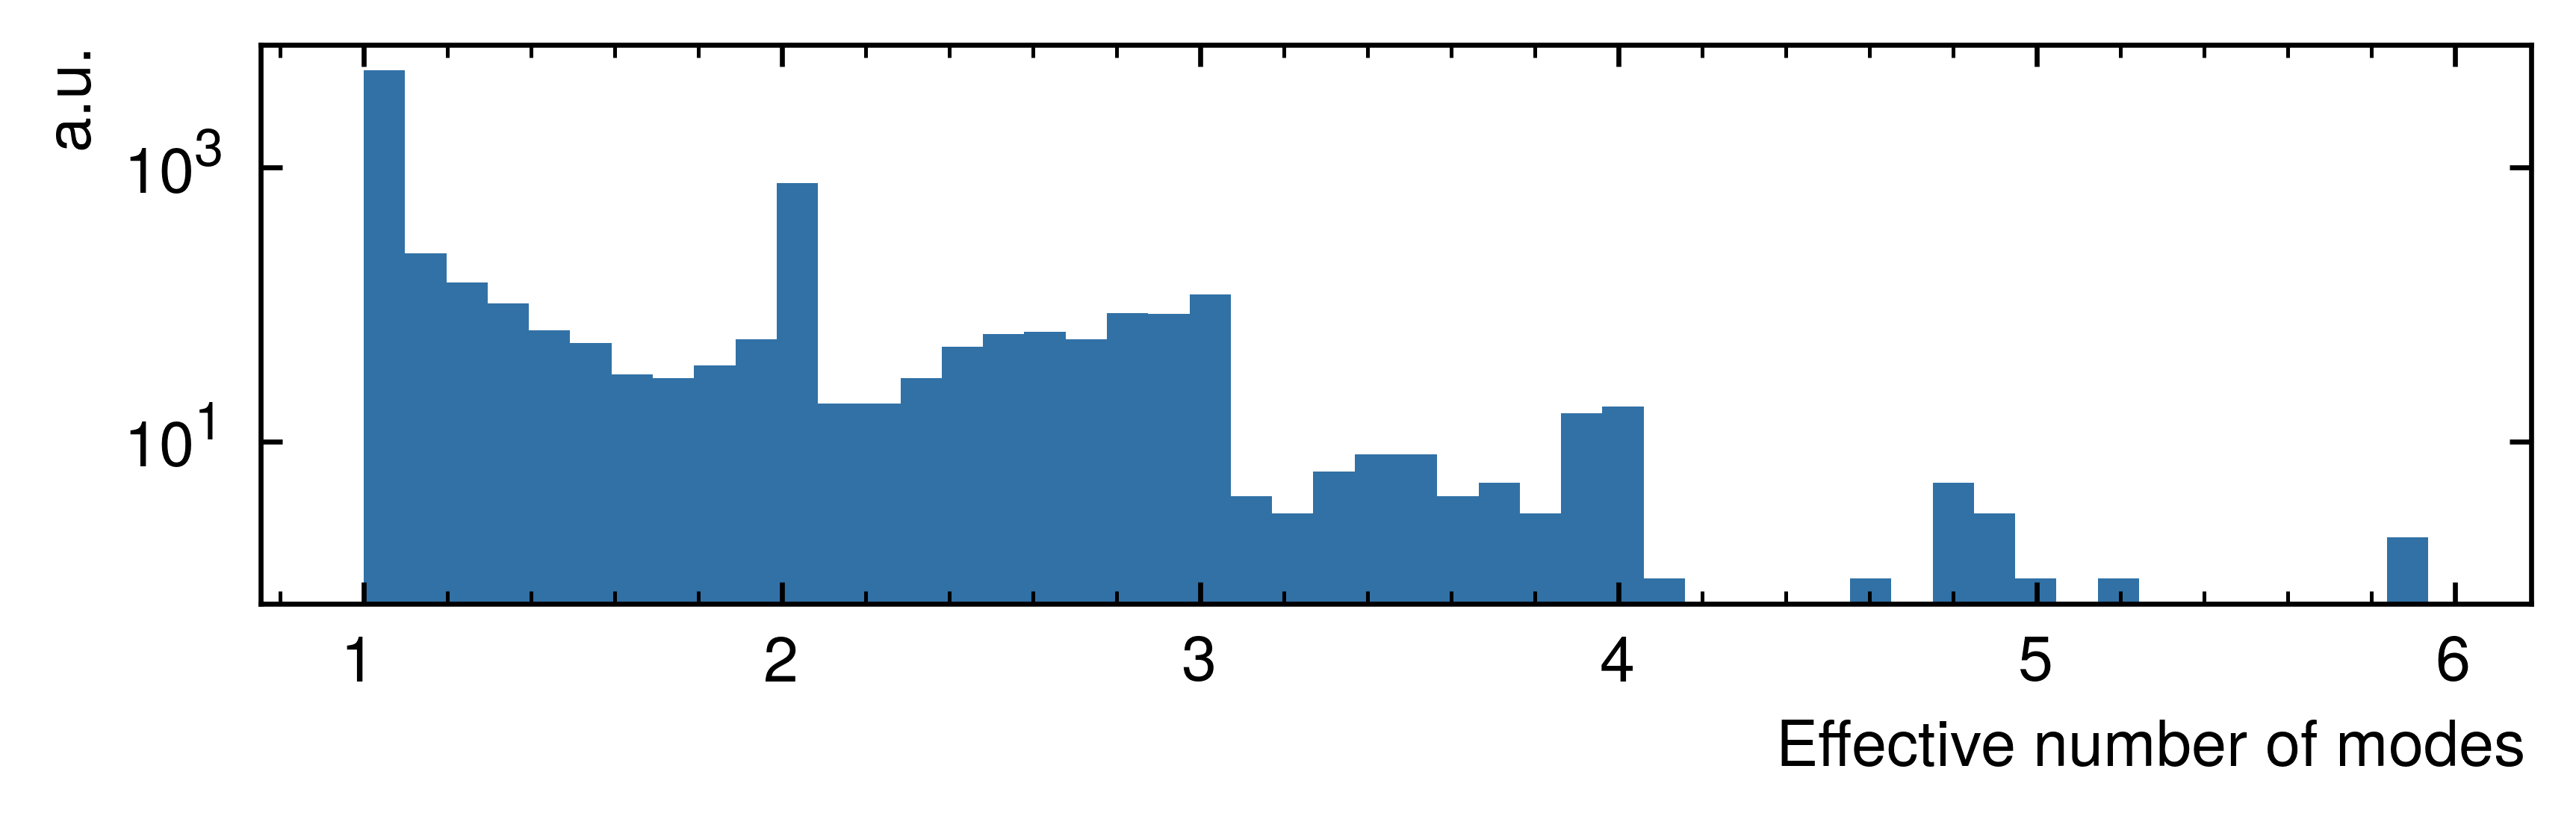

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
vals, _, _ = ax.hist([n for _, n in num_modes_rel])
ax.set_ylabel("Counts")
ax.set_xlabel("Effective number of modes")
fig.tight_layout()
ax.set_yscale("log")

plt.show()

In [31]:
min_num_modes = min([n for _, n in num_modes])
max_num_modes = max([n for _, n in num_modes])

i_per_mode = []
for N in range(min_num_modes, max_num_modes+1):
    i_per_mode.append([i for i, n in num_modes if n==N])

Estimated number of modes: 1
Pdf vals: [0.5988577]
Reestimated number of modes: 1
Pdf vals: [0.5990161]


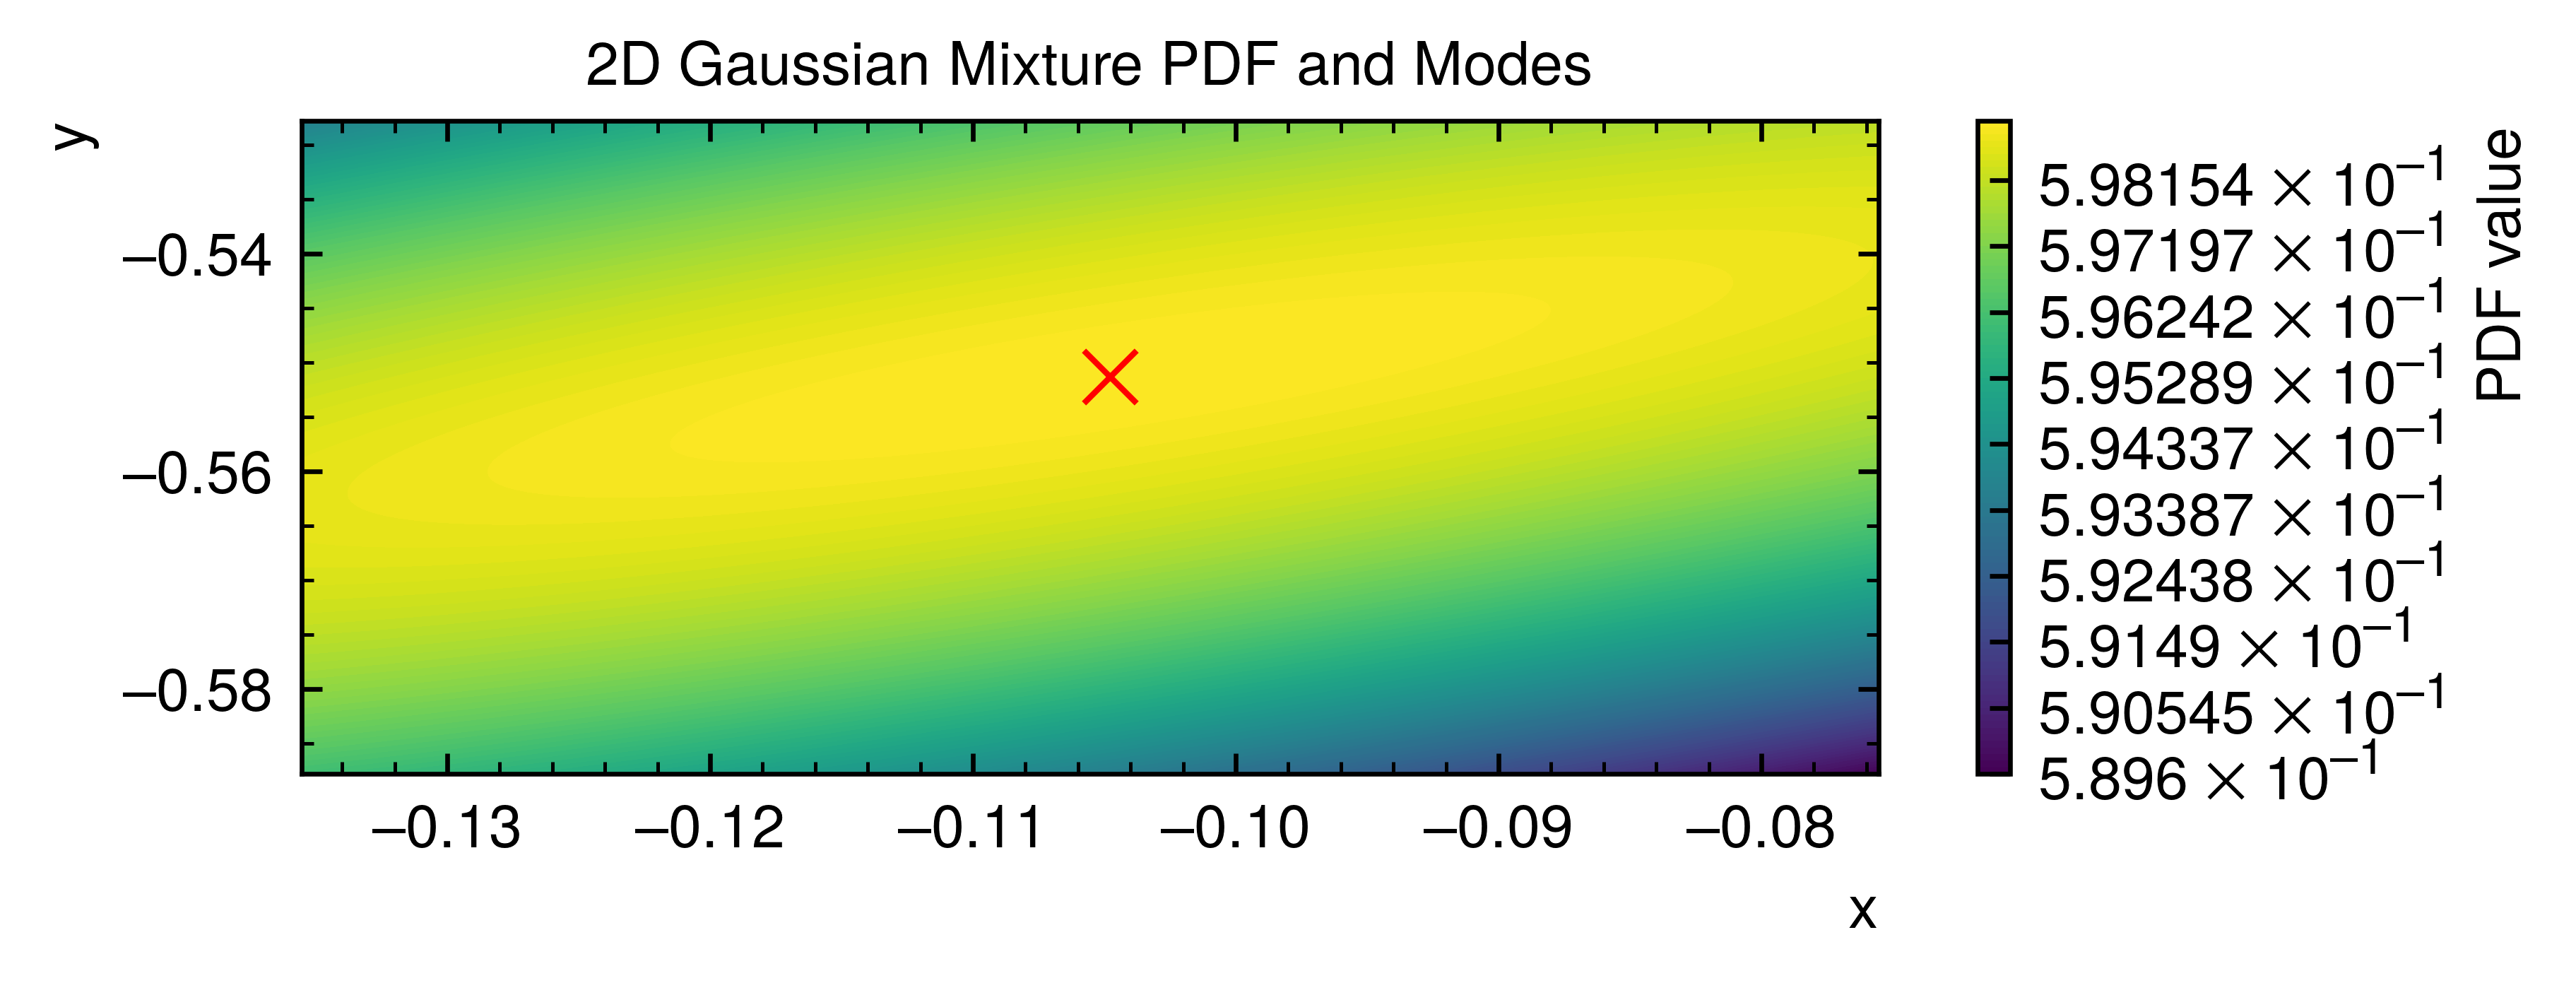

Estimated number of modes: 2
Pdf vals: [1.0289242 1.0242598]
Reestimated number of modes: 2
Pdf vals: [1.0294286 1.0294287]


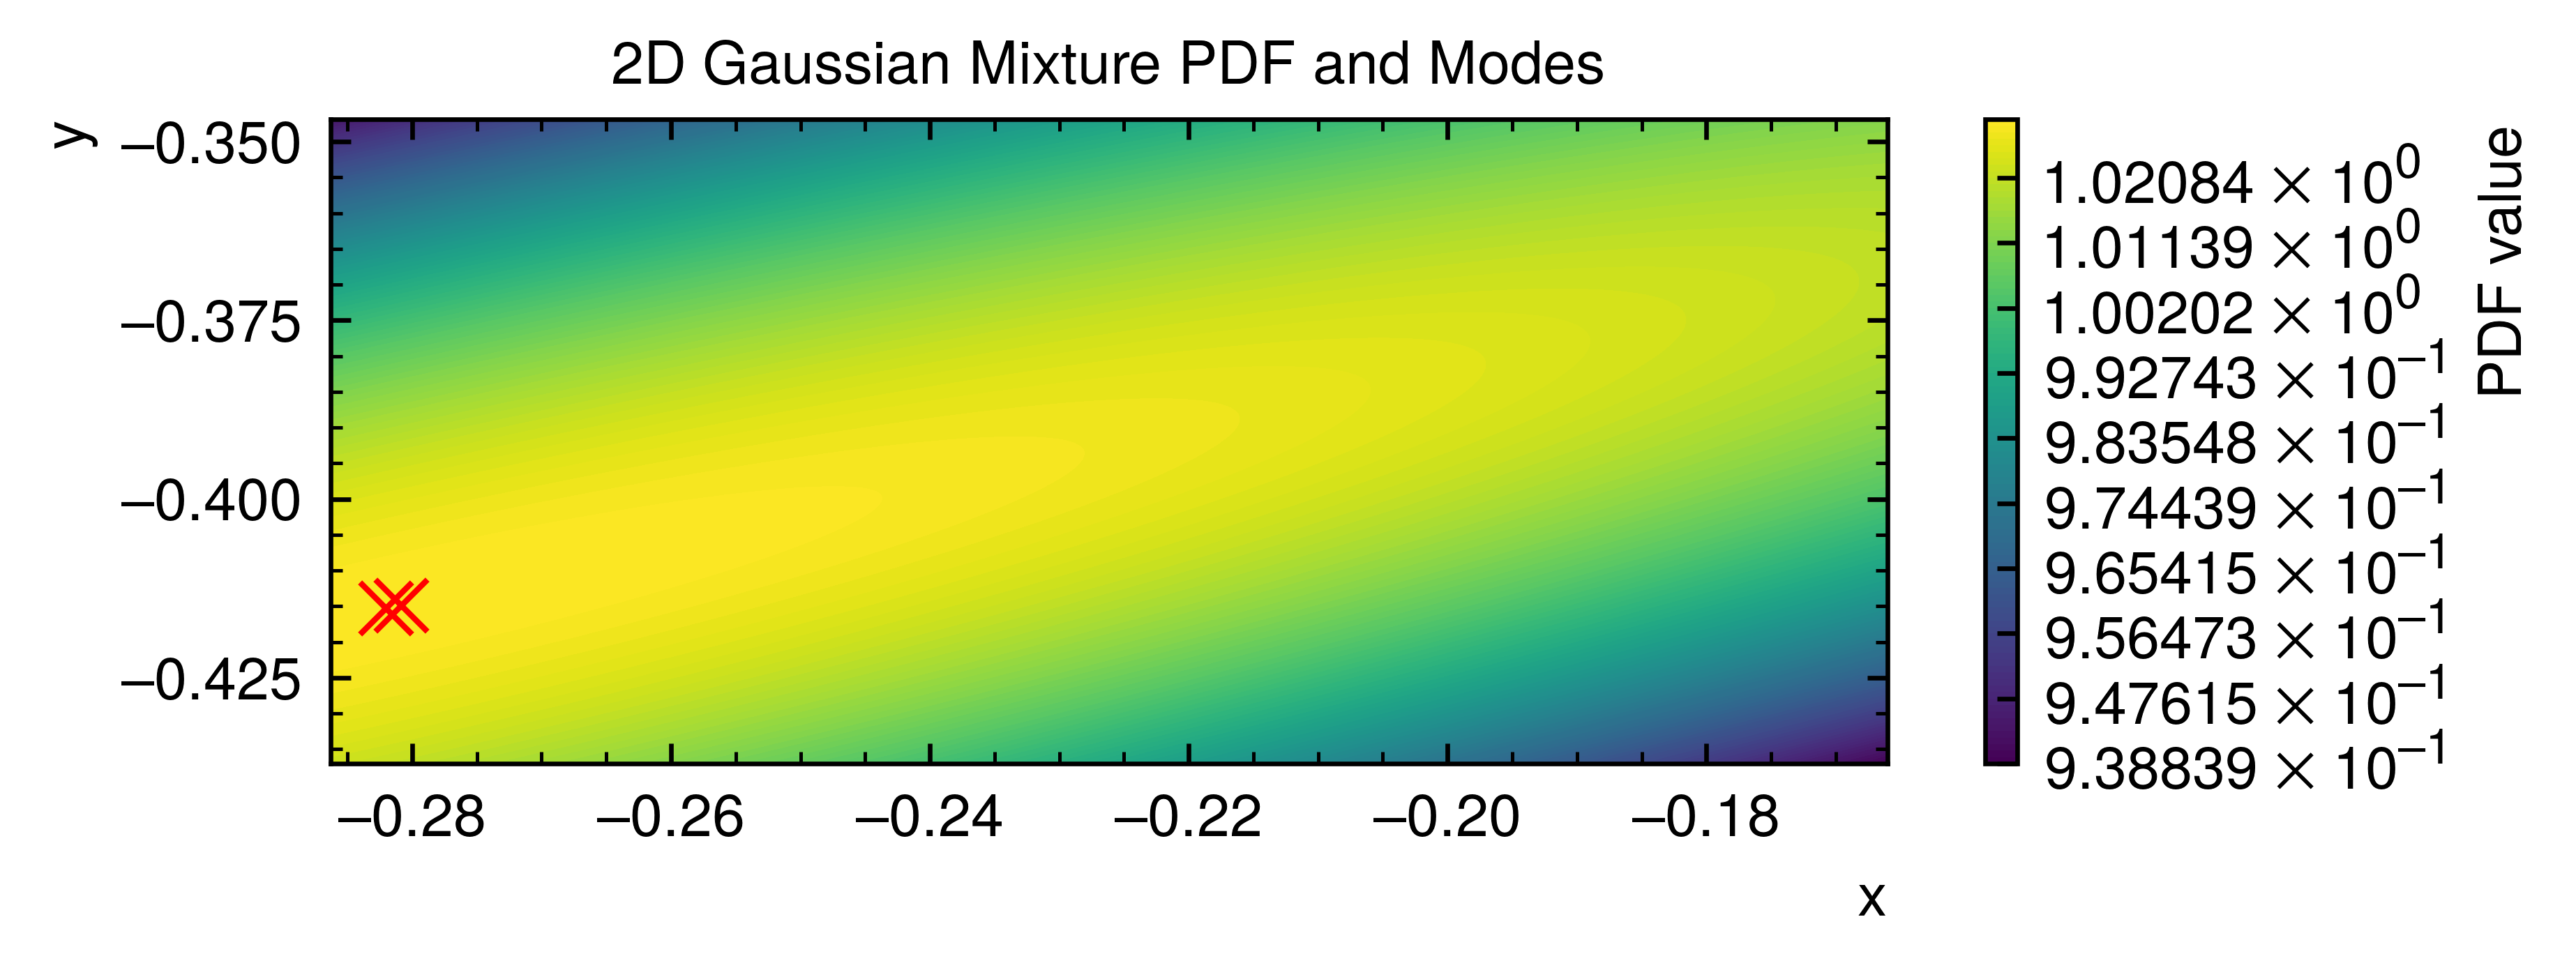

Estimated number of modes: 3
Pdf vals: [4.5840082e+00 2.0671247e-03 2.2618329e-02]
Reestimated number of modes: 3
Pdf vals: [4.6000452e+00 2.0675724e-03 2.2620684e-02]


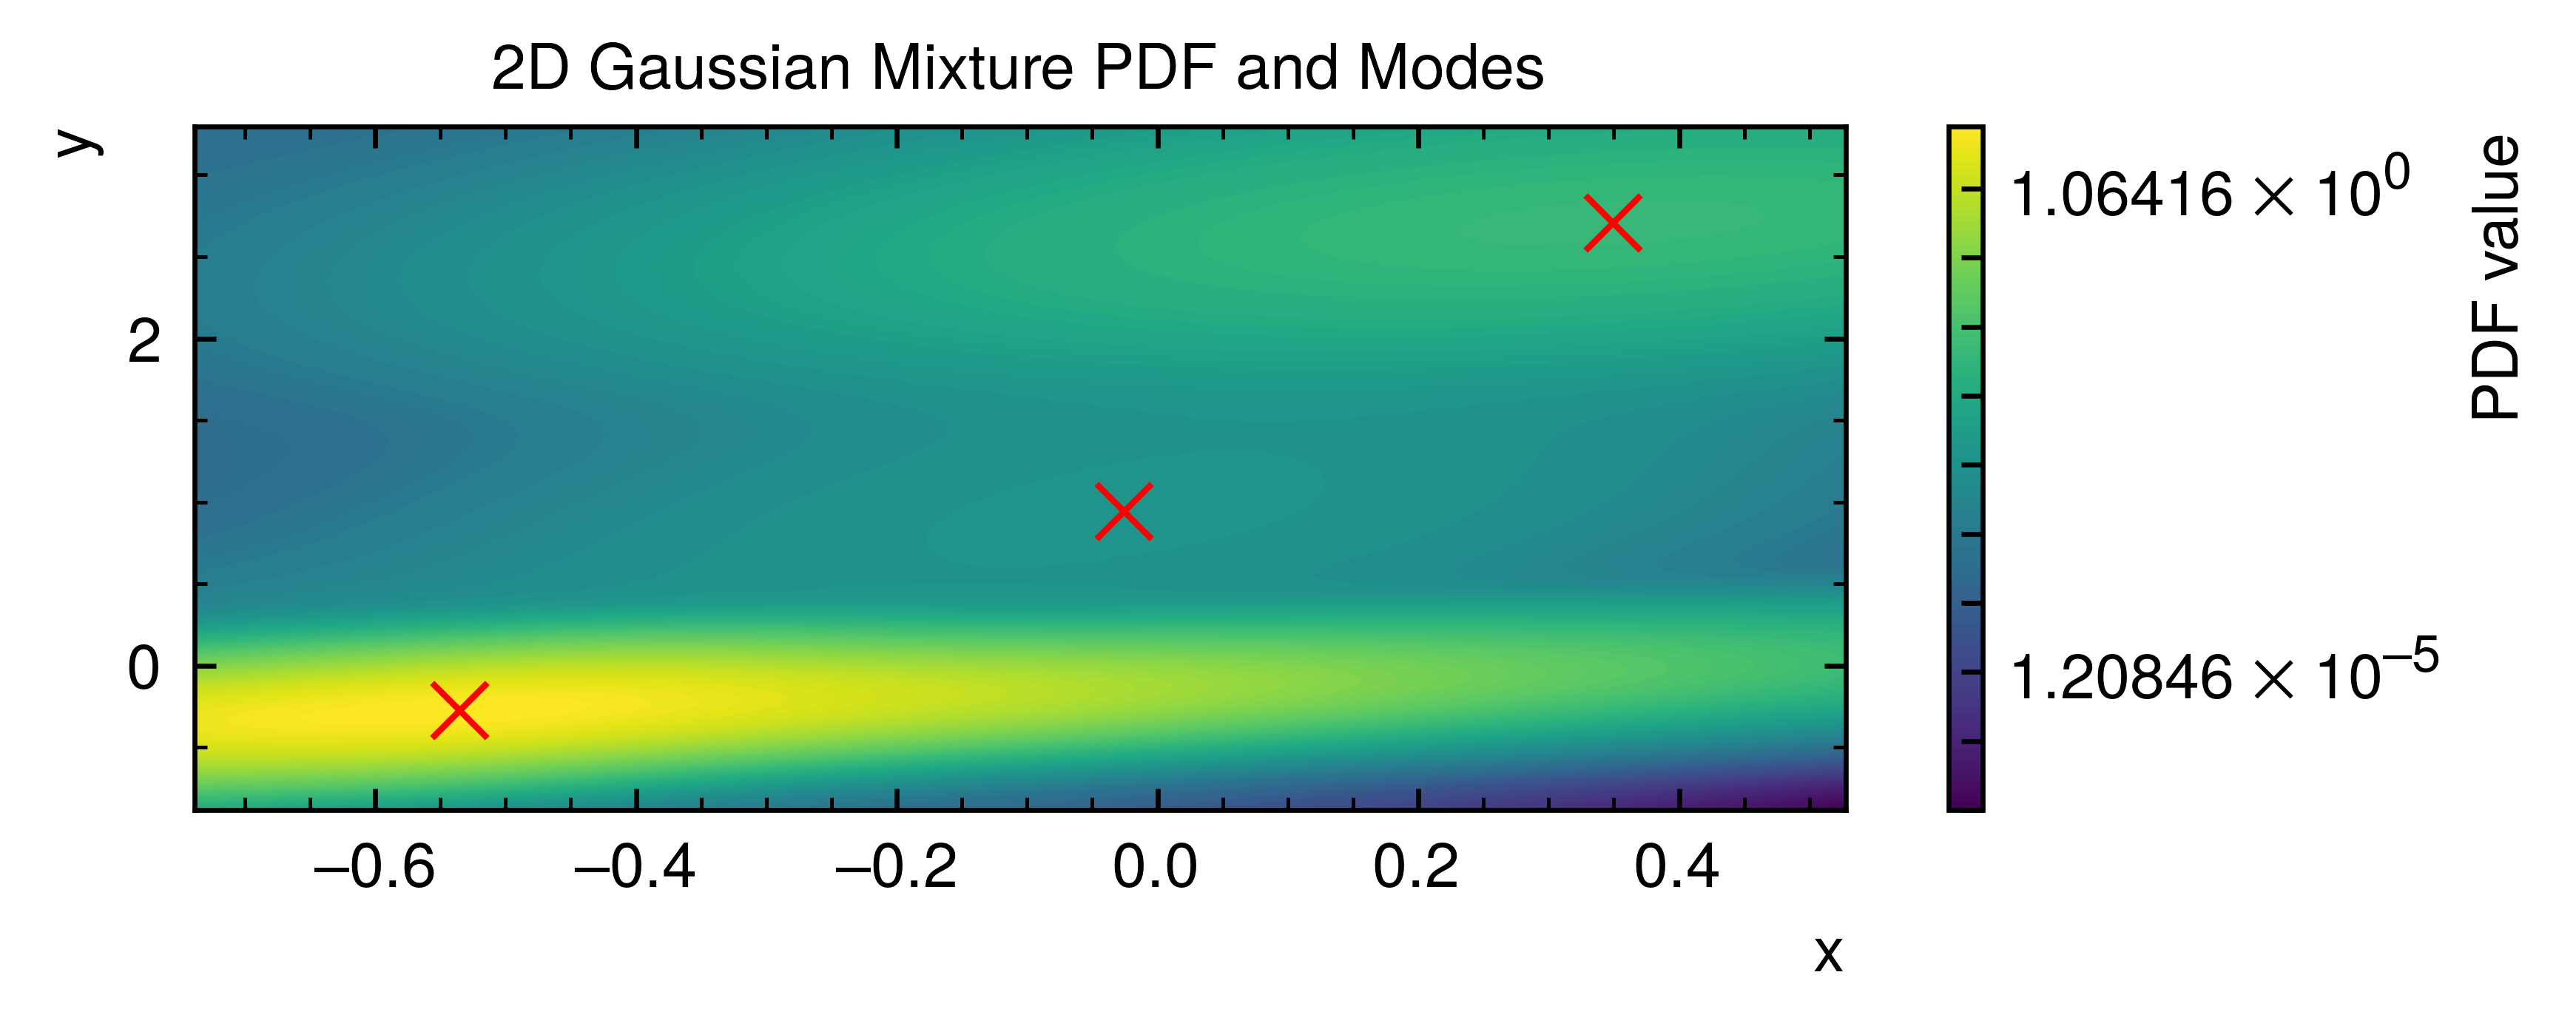

Estimated number of modes: 4
Pdf vals: [1.4733400e-02 2.0807126e+00 2.6350503e-05 2.5031411e-06]
Reestimated number of modes: 4
Pdf vals: [1.4730305e-02 2.0793157e+00 2.6355212e-05 1.1632260e-05]


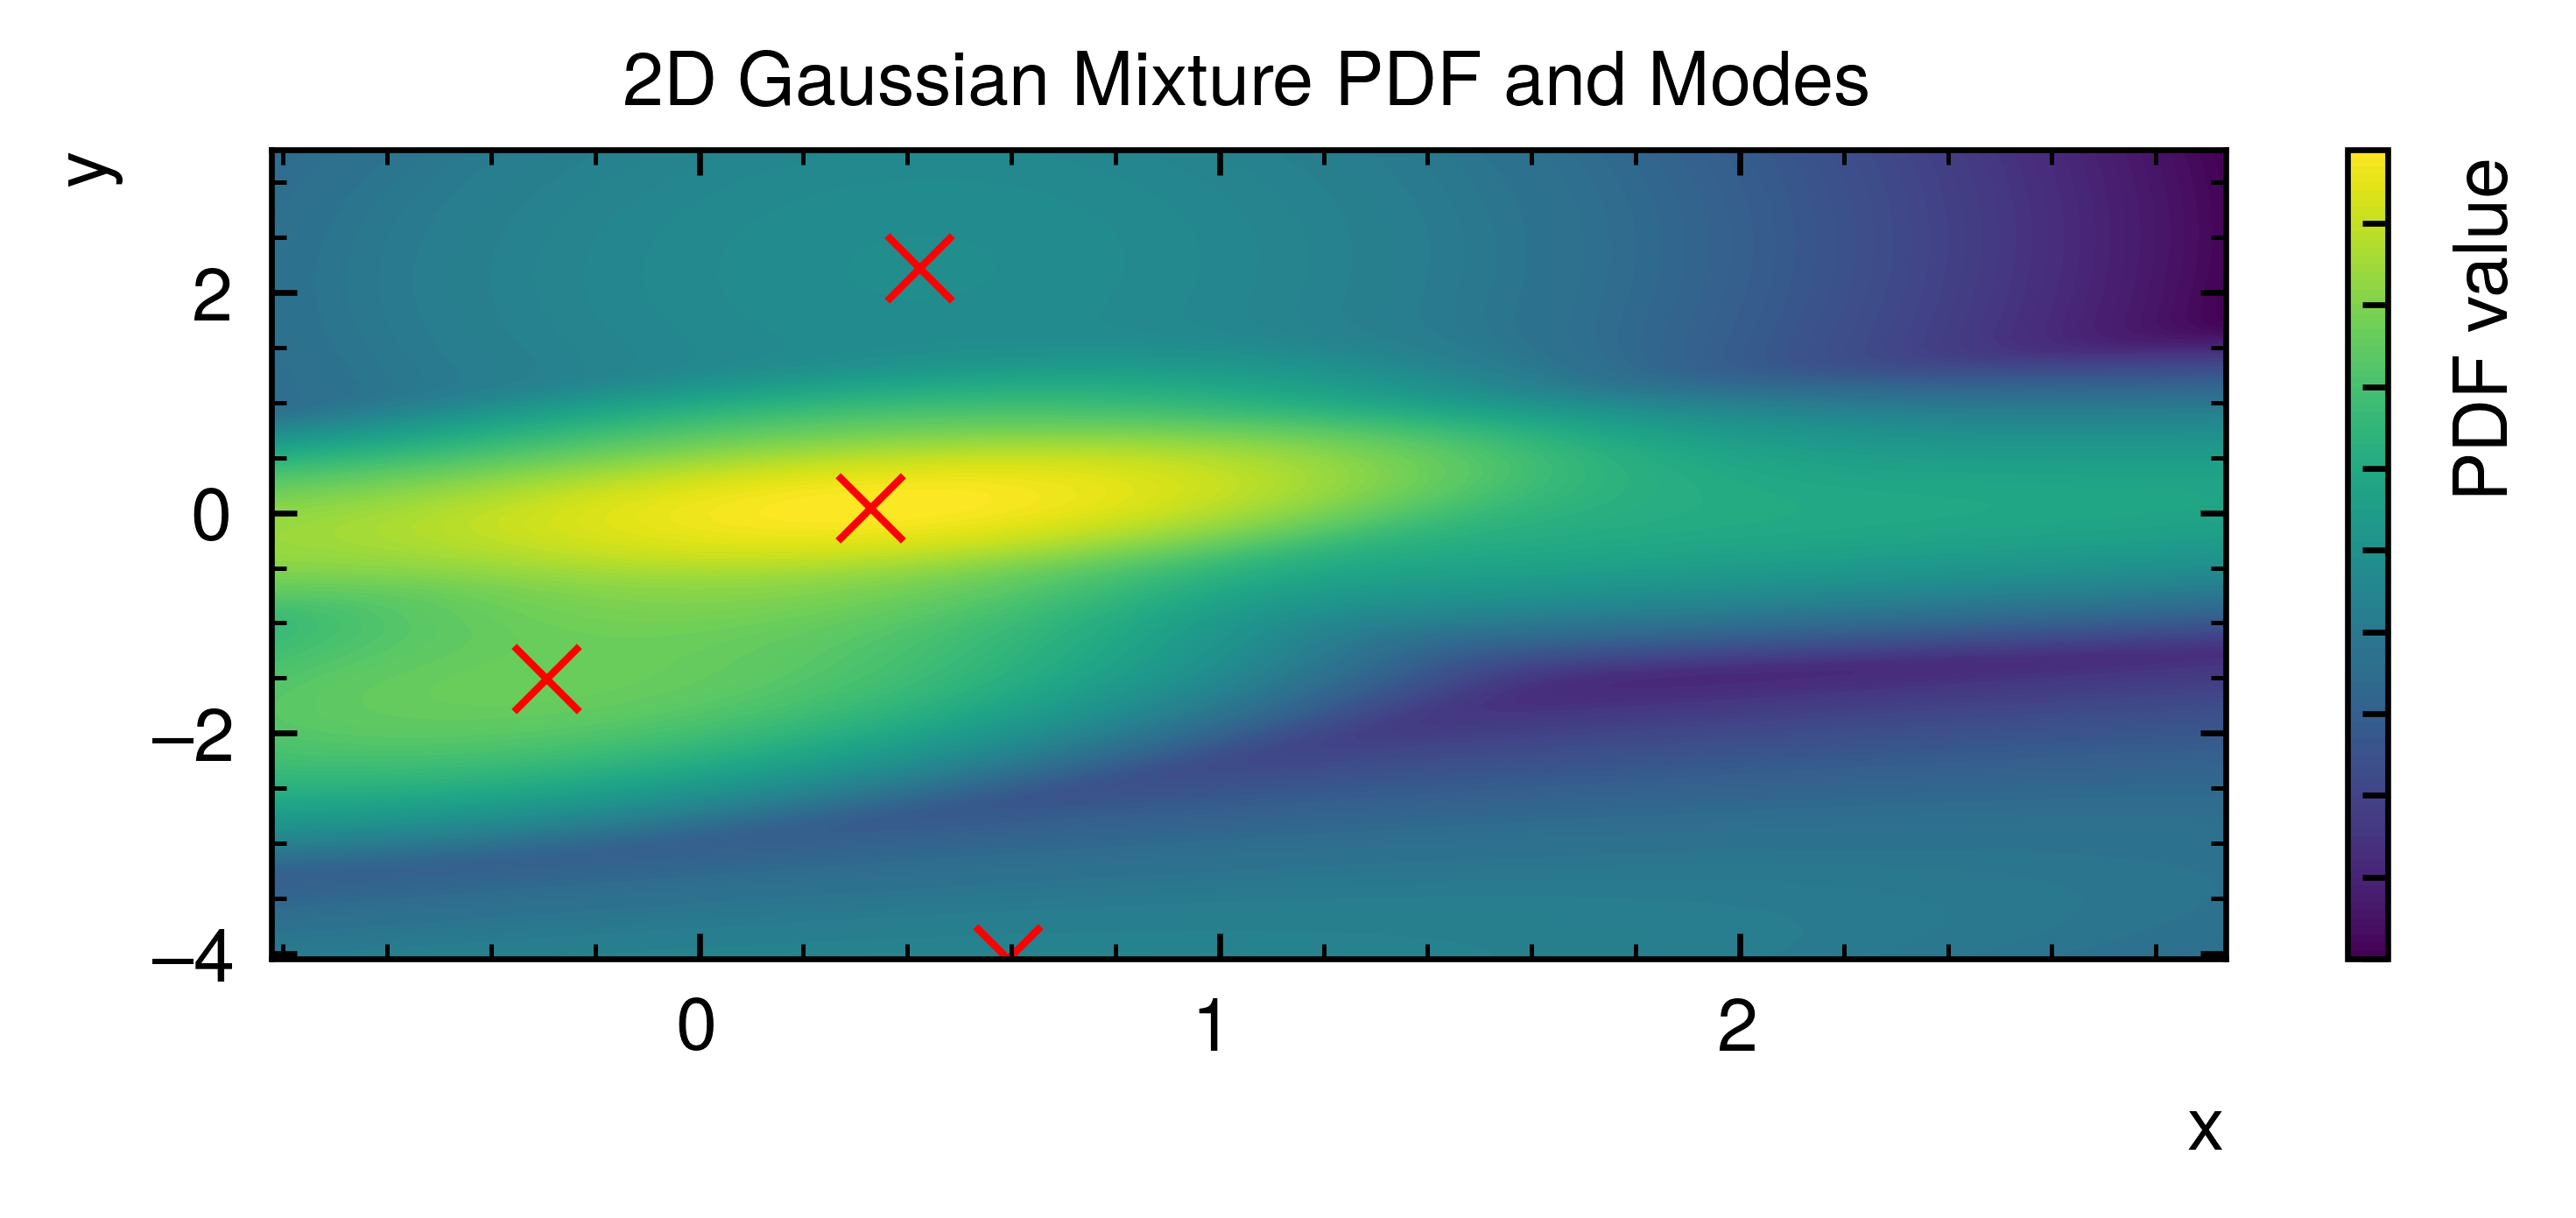

Estimated number of modes: 5
Pdf vals: [4.4996479e-05 2.2144666e+00 2.2287173e+00 2.2149367e+00 2.1665111e+00]
Reestimated number of modes: 4
Pdf vals: [5.6500296e-05 2.2286961e+00 2.2282848e+00 2.2151349e+00]


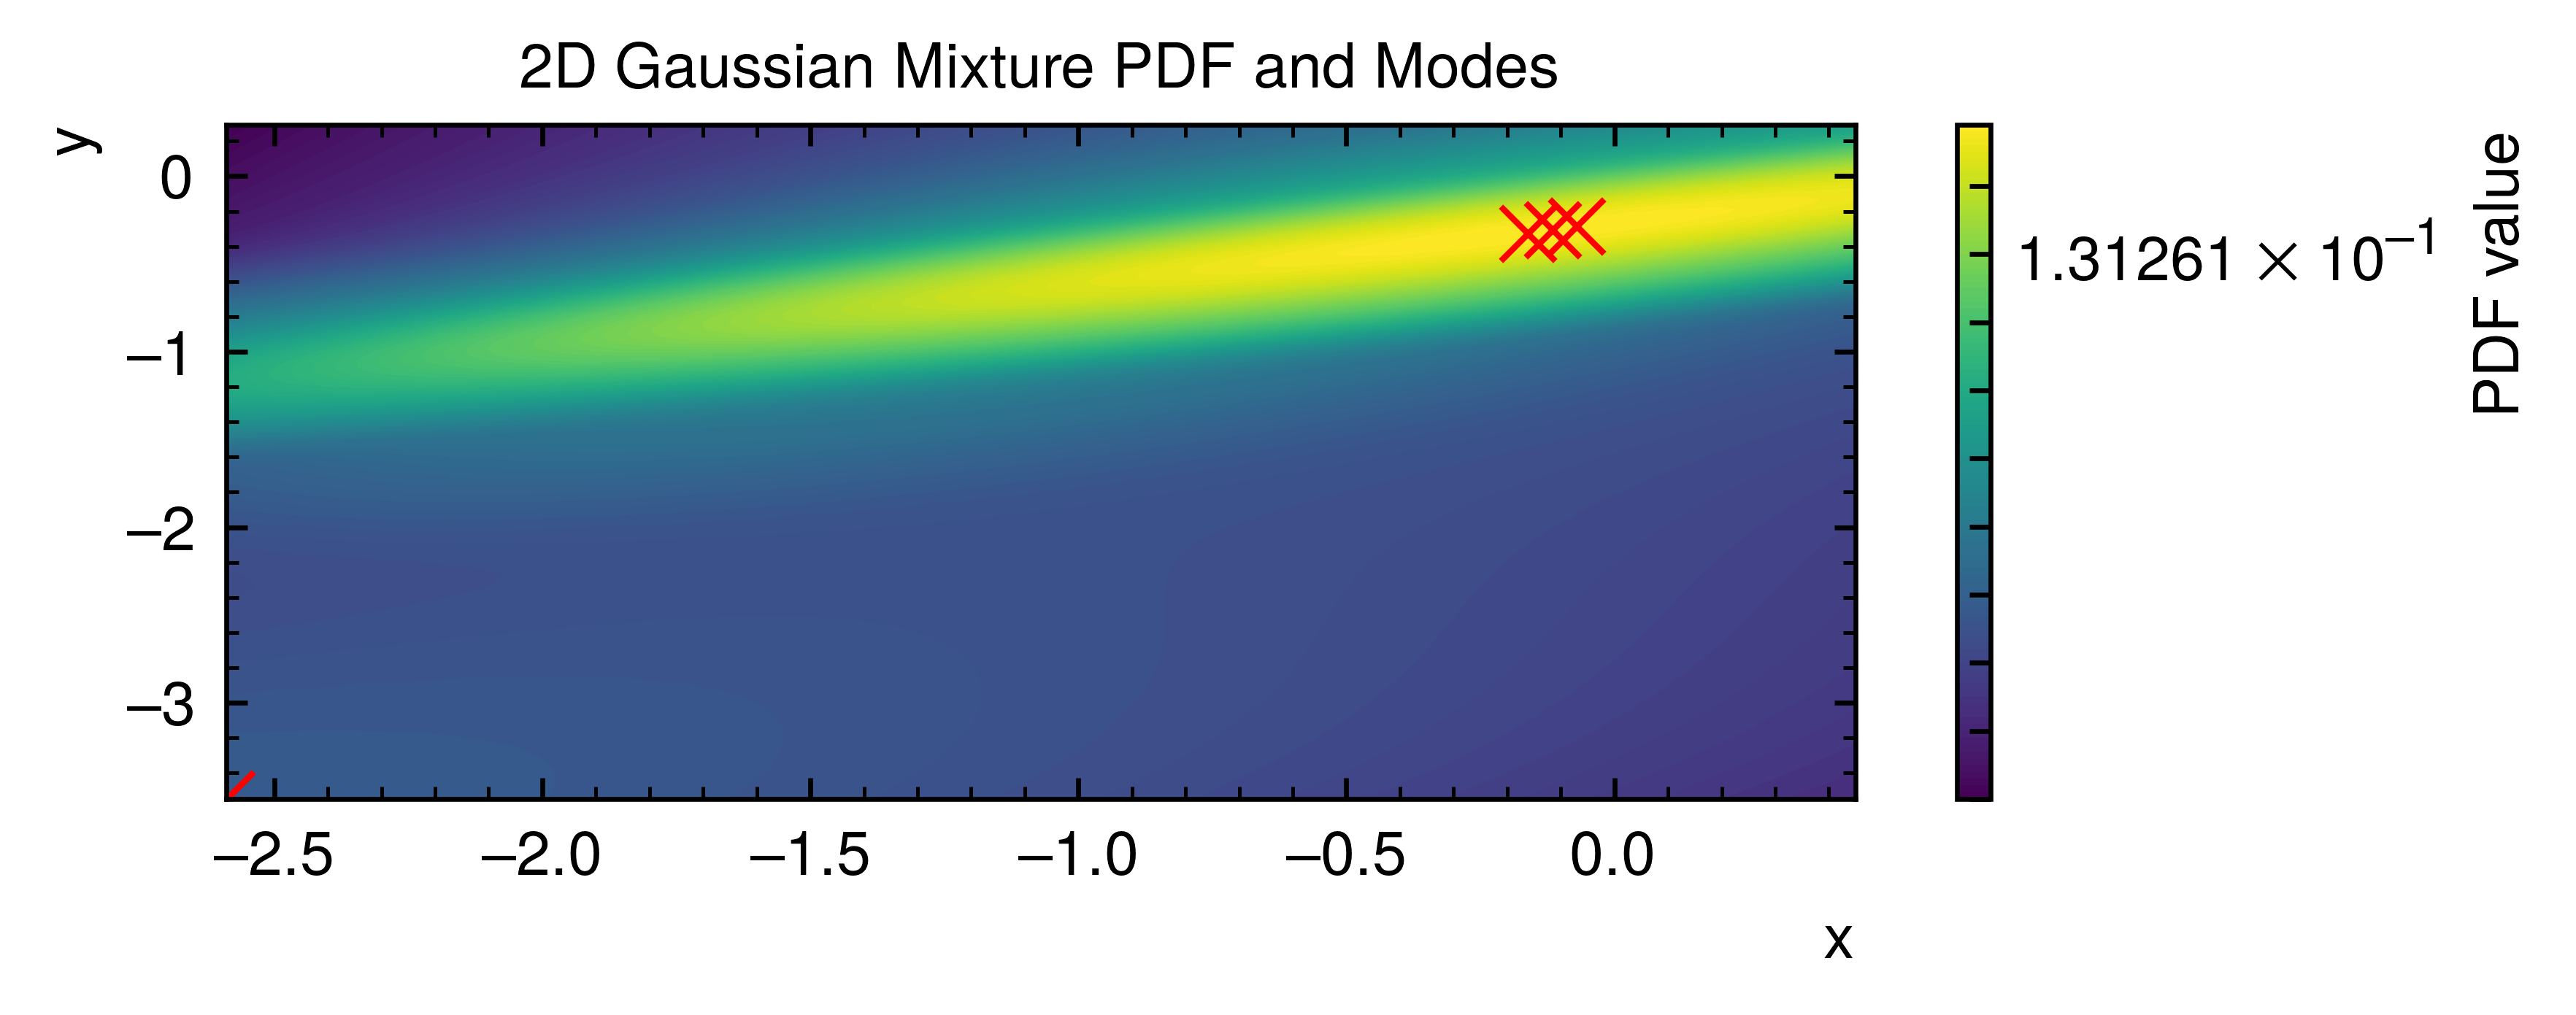

Estimated number of modes: 6
Pdf vals: [9.8302386e-05 4.0306337e-03 4.0466143e-03 4.0312978e-03 4.1332951e+00
 9.4540155e-07]
Reestimated number of modes: 7
Pdf vals: [1.0055415e-04 4.0153801e-03 4.0463121e-03 4.0249634e-03 3.9603361e-03
 4.1298695e+00 9.5456767e-07]


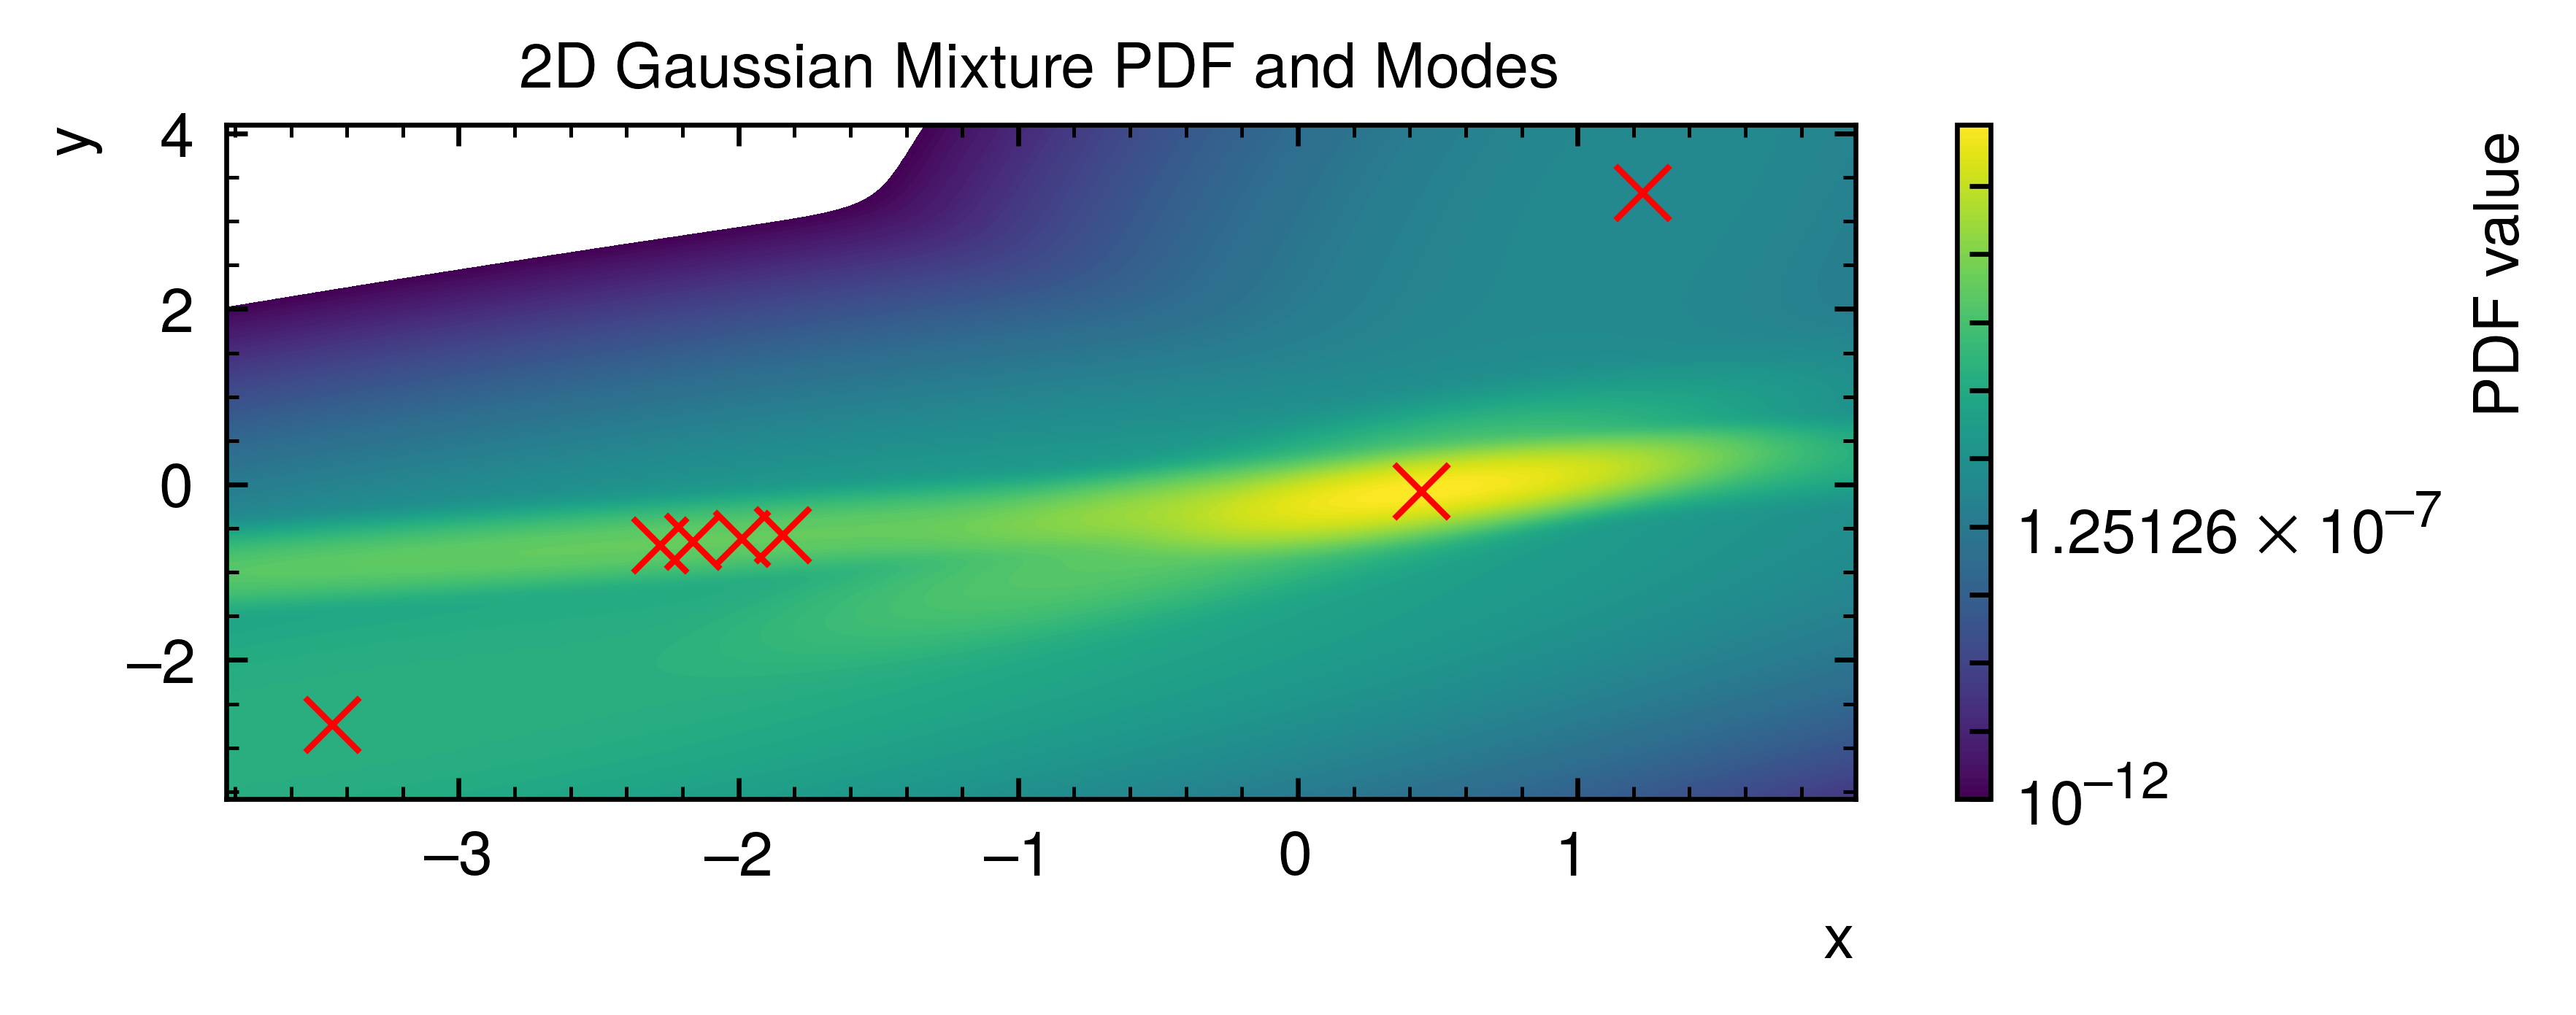

Estimated number of modes: 7
Pdf vals: [1.2544179e-04 5.4517436e+00 5.6307292e+00 5.5905967e+00 5.4236827e+00
 5.0910301e+00 1.9302339e-05]
Reestimated number of modes: 10
Pdf vals: [1.5511371e-04 5.0058489e+00 5.4230886e+00 5.6283369e+00 5.6082063e+00
 5.3857574e+00 5.0046759e+00 1.9302888e-05 4.5157852e+00 3.9672036e+00]


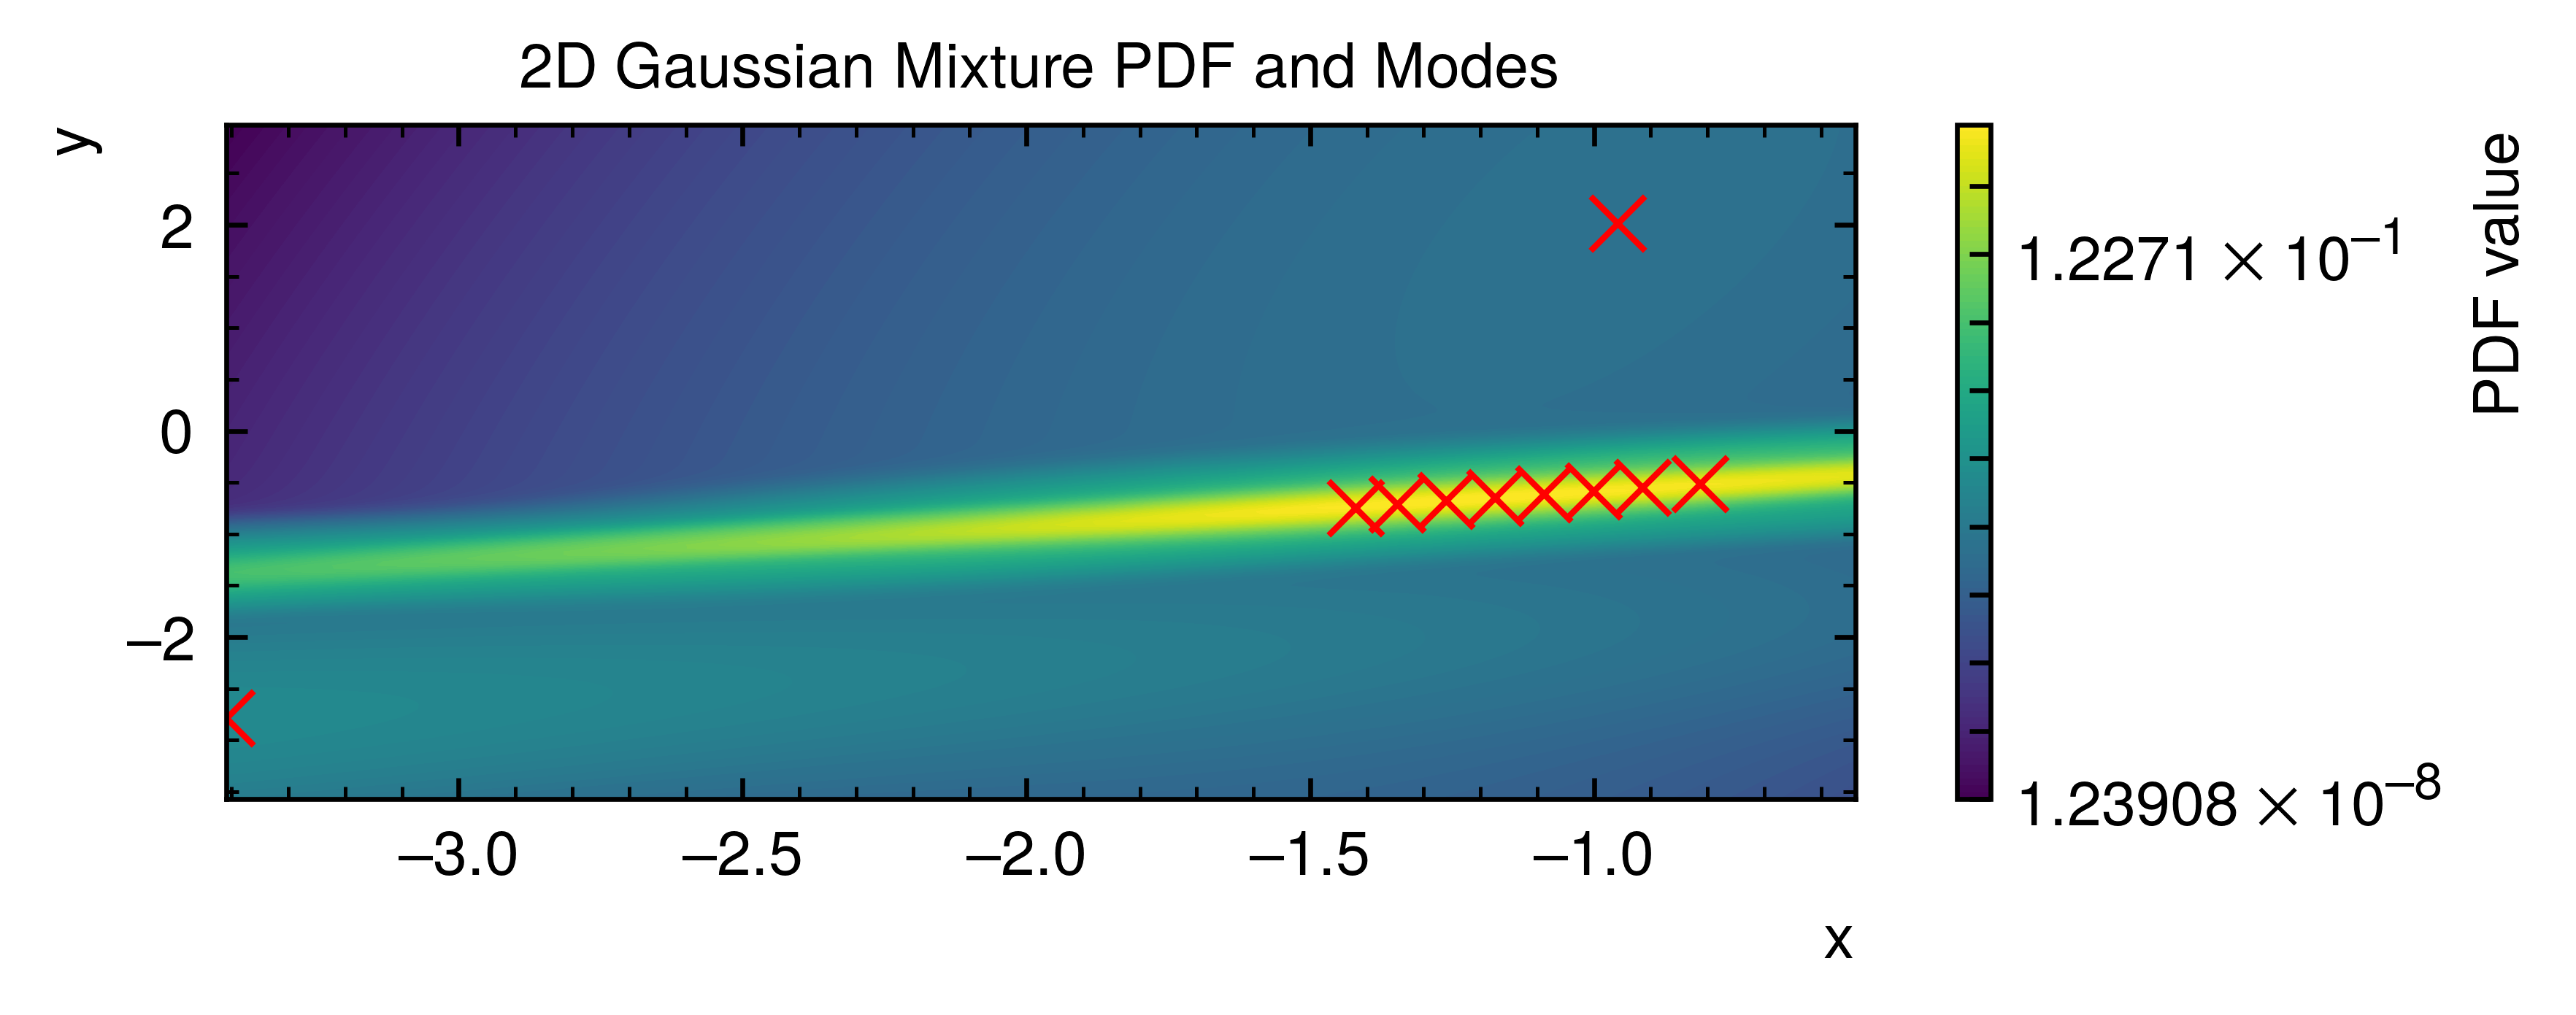

Estimated number of modes: 8
Pdf vals: [0.01344645 0.01379159 0.01405064 0.01425551 0.01442727 7.1003737
 7.353564   7.2700024 ]
Reestimated number of modes: 1
Pdf vals: [7.375322]


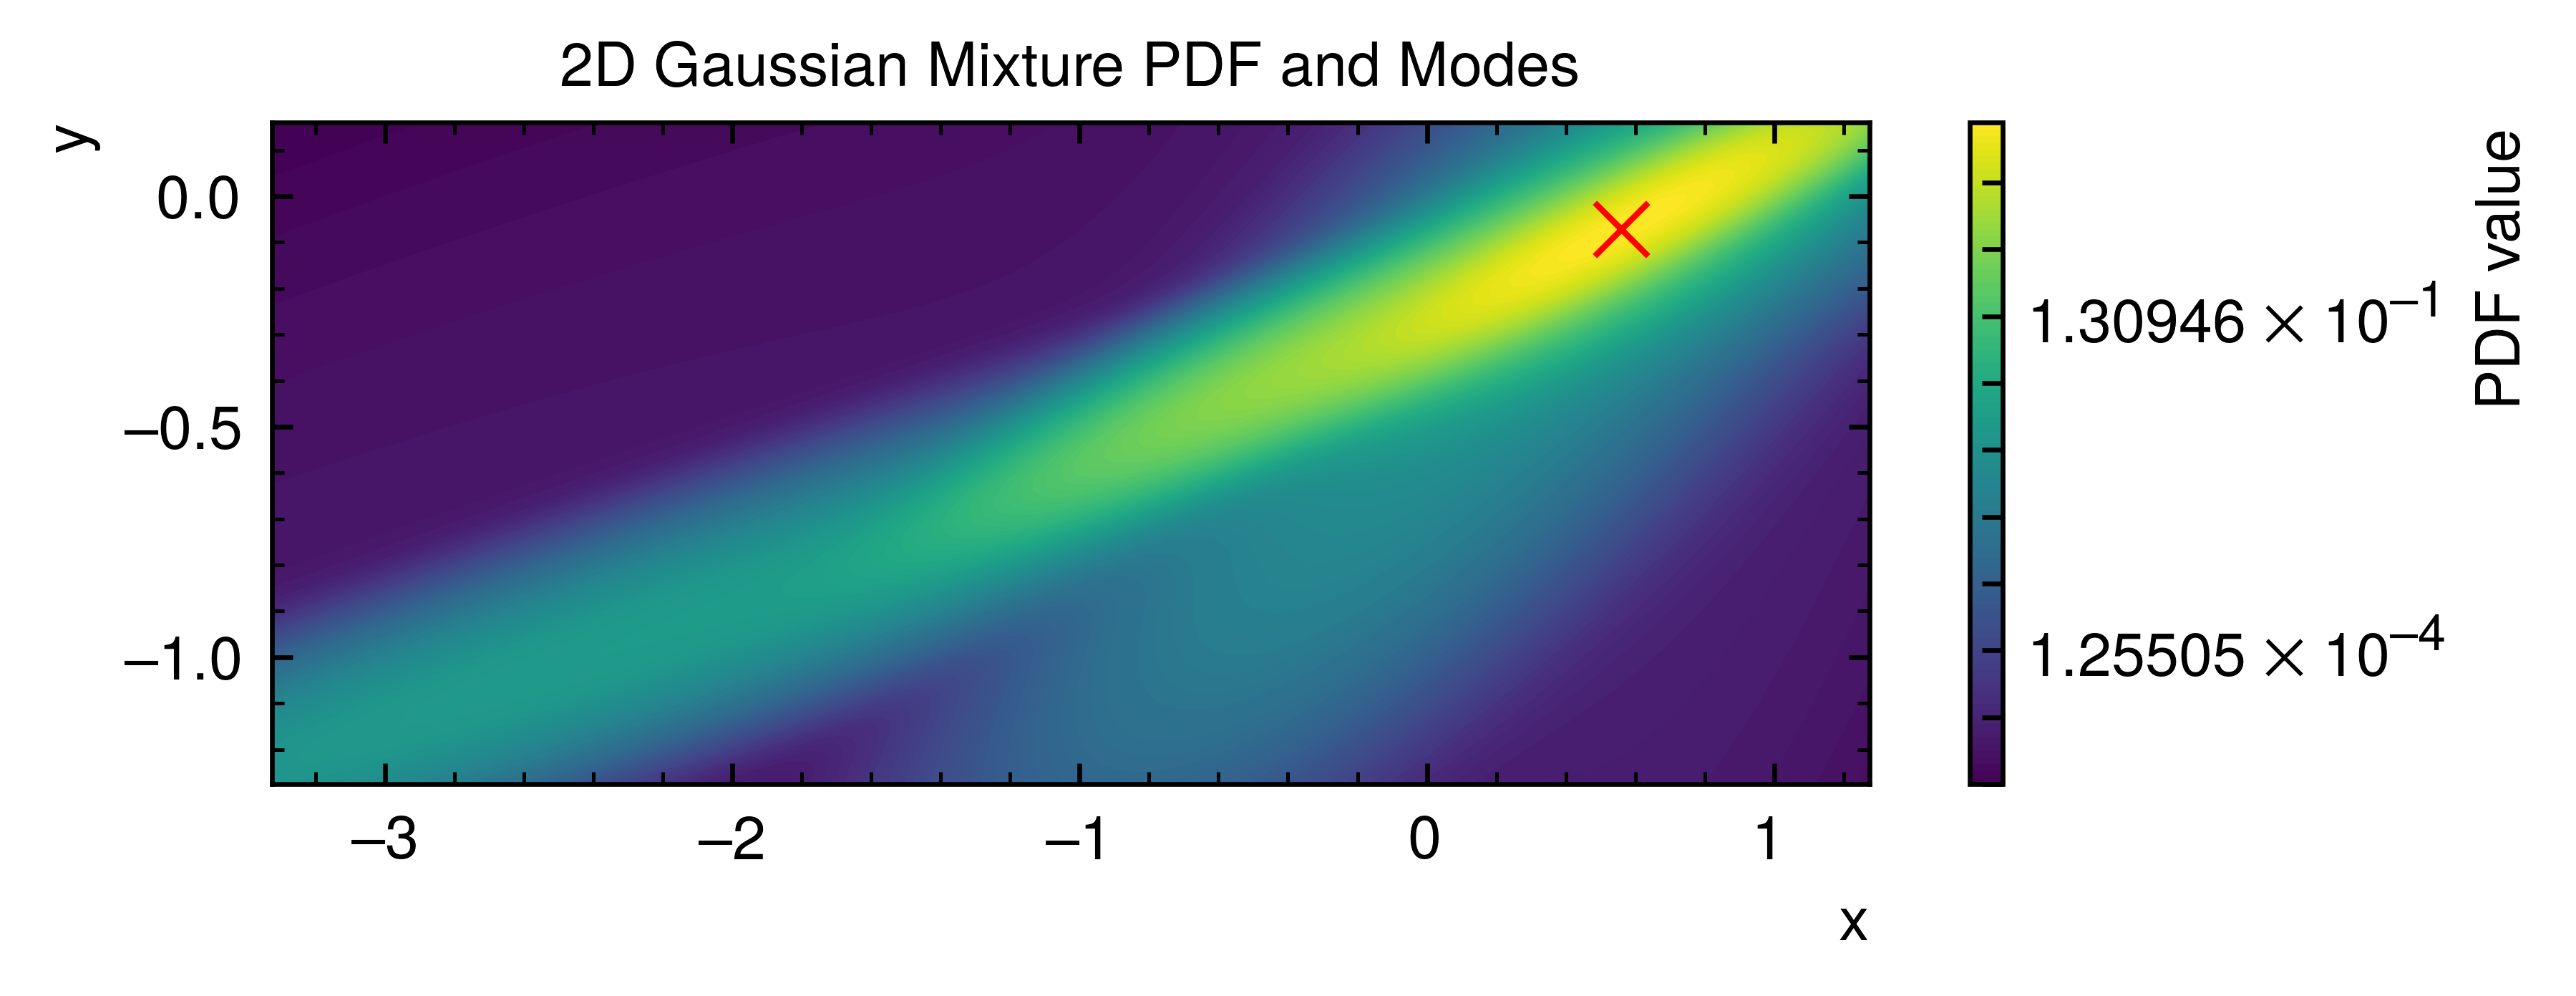

Estimated number of modes: 9
Pdf vals: [0.07007478 0.07114431 0.07189901 0.07239196 0.07277066 0.07336805
 5.4878573  5.724332   5.6887593 ]
Reestimated number of modes: 1
Pdf vals: [5.7447057]


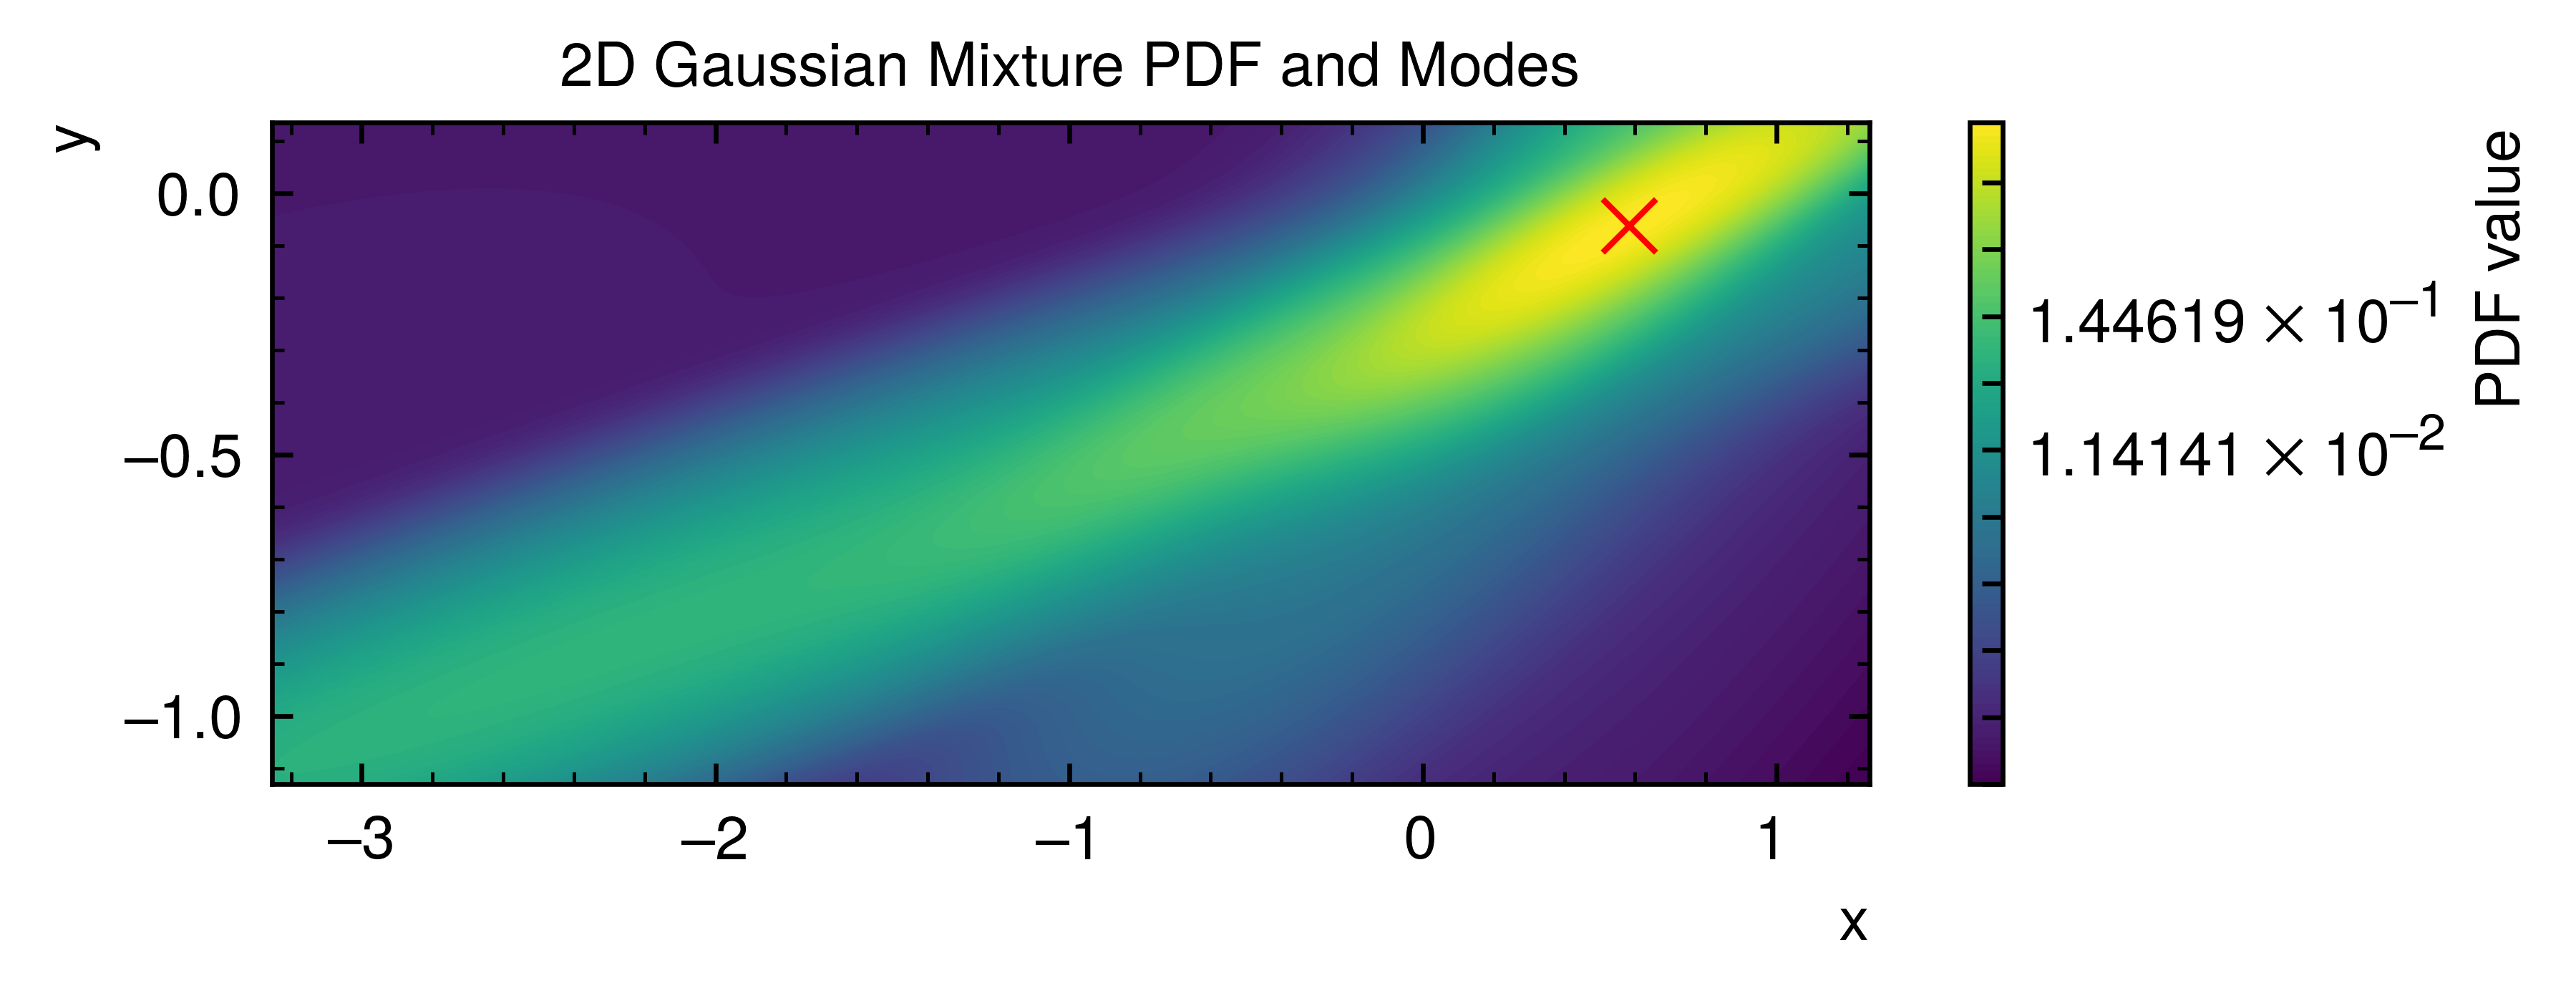

Estimated number of modes: 10
Pdf vals: [ 0.01610375  0.0163265   0.01639567  0.01631871  0.01613222  0.01581715
  0.0154645  12.425613   12.348899   11.514896  ]
Reestimated number of modes: 3
Pdf vals: [ 0.0164014 12.479087  12.508504 ]


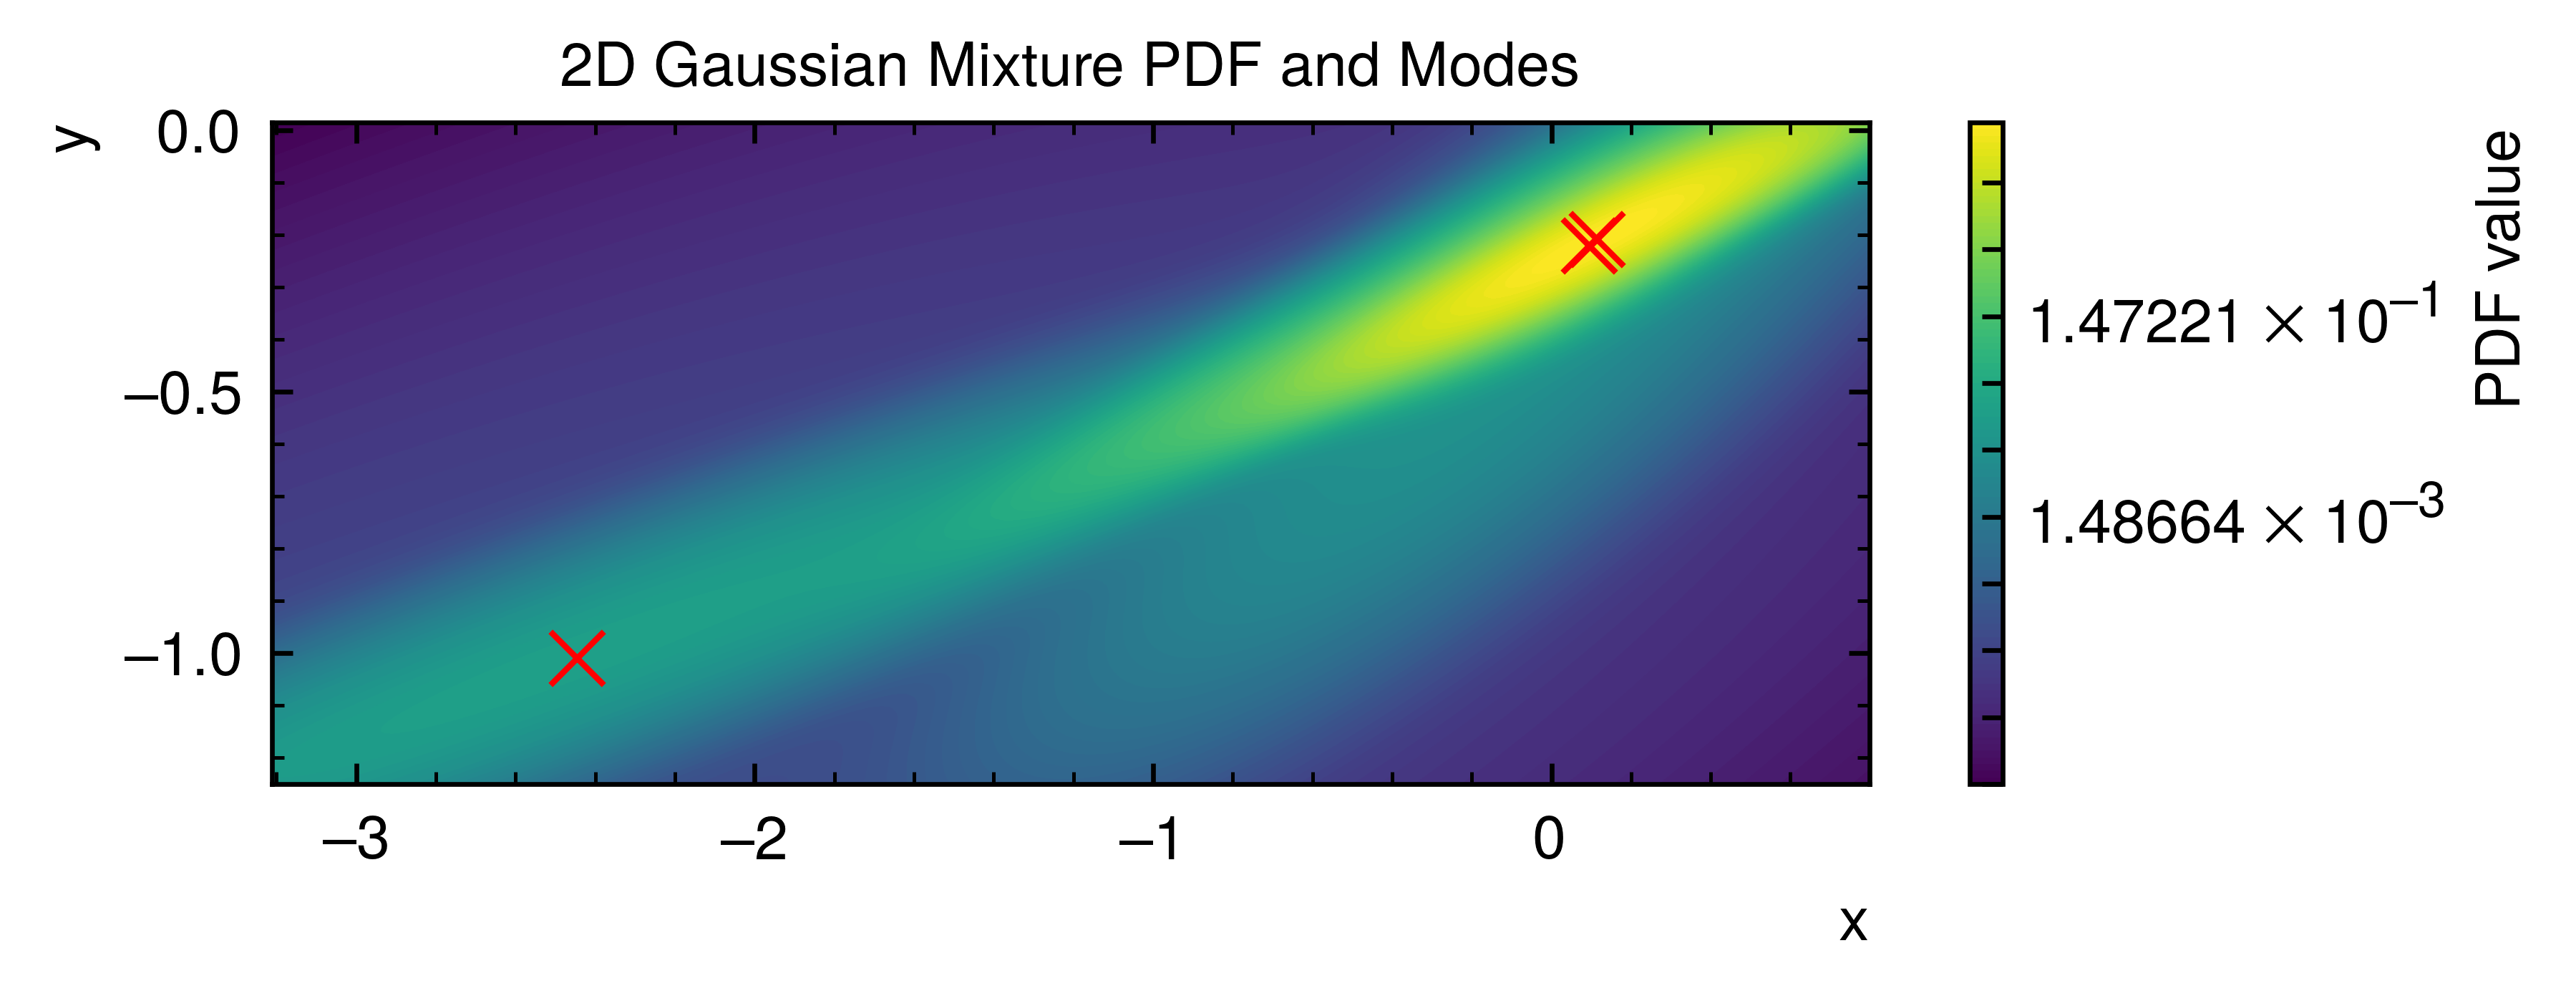

In [62]:
for N in range(max_num_modes-min_num_modes+1):
    i = i_per_mode[N][0]
    compute_eff_number_of_modes_with_vis(
        weights = pred["weights"][i],
        mus = pred["mu"][i],
        sigmas = pred["sigma"][i],
        rel_threshold=0.0
    )